Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [18]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 11 - Asset allocation

## 11.1 Evaluating an equally-weighted portfolio's performance

### How to do it...

1. Import the libraries:

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import quantstats as qs

2. Define the considered assets and download their prices from Yahoo Finance:

[*********************100%***********************]  5 of 5 completed


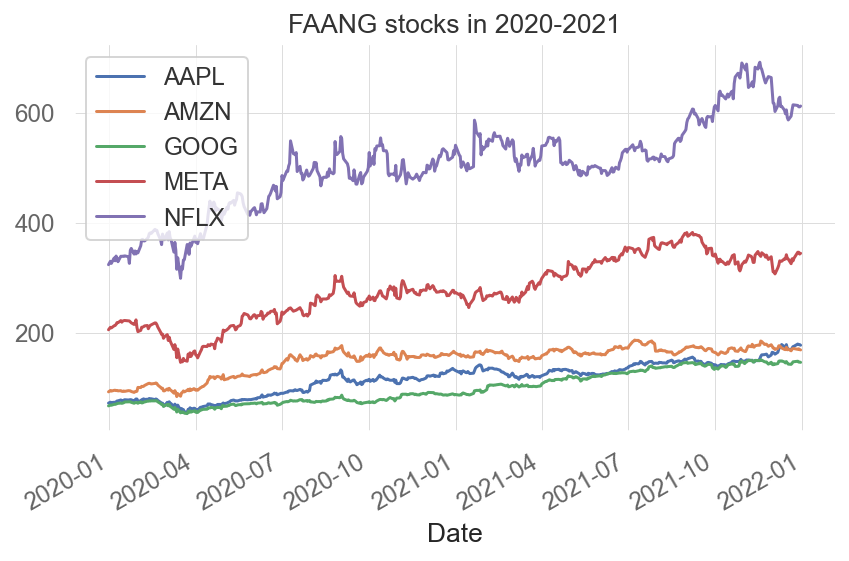

In [6]:
ASSETS = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
n_assets = len(ASSETS)

prices_df = yf.download(ASSETS, 
                        start="2020-01-01", 
                        end="2021-12-31", 
                        adjusted=True)
prices_df["Adj Close"].plot(title="FAANG stocks in 2020-2021")

sns.despine()
plt.tight_layout()


3. Calculate individual asset returns:

In [7]:
returns = prices_df["Adj Close"].pct_change().dropna()

4. Define the weights:

In [8]:
portfolio_weights = n_assets * [1 / n_assets]

5. Calculate portfolio returns:

In [9]:
portfolio_returns = pd.Series(
    np.dot(portfolio_weights, returns.T), 
    index=returns.index
)

6. Generate basic performance evaluation plots:

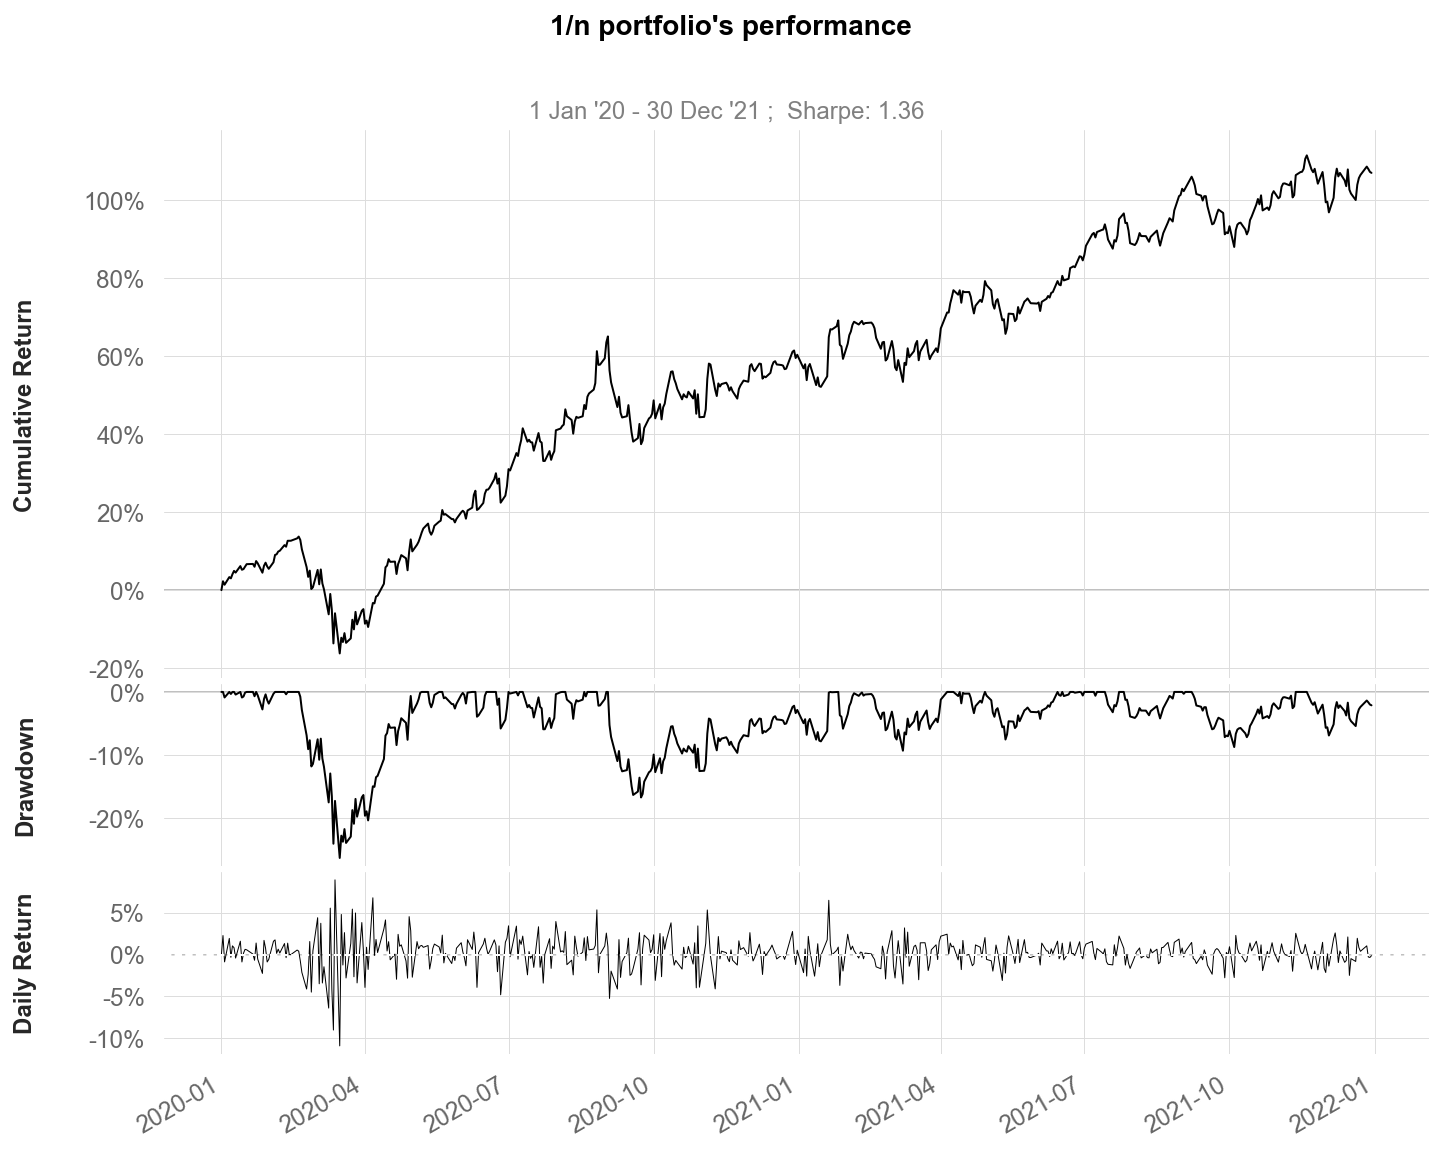

In [10]:
qs.plots.snapshot(portfolio_returns, 
                  title="1/n portfolio's performance", 
                  grayscale=True)

7. Calculate the basic portfolio evaluation metrics:

In [11]:
qs.reports.metrics(portfolio_returns, 
                   benchmark="SPY", 
                   mode="basic")

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-01-02  2020-01-02
End Period          2021-12-30  2021-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   107.0%      51.3%
CAGR﹪              44.02%      23.07%

Sharpe              1.36        0.94
Sortino             1.96        1.3
Sortino/√2          1.39        0.92
Omega               1.28        1.28

Max Drawdown        -26.35%     -33.72%
Longest DD Days     140         172

Gain/Pain Ratio     0.28        0.22
Gain/Pain (1M)      3.48        1.54

Payoff Ratio        0.84        0.8
Profit Factor       1.28        1.22
Common Sense Ratio  1.21        0.97
CPC Index           0.63        0.57
Tail Ratio          0.94        0.8
Outlier Win Ratio   4.13        5.68
Outlier Loss Ratio  3.3         4.46

MTD                 1.56%       4.89%
3M                  8.24%       10.17%
6M                  11.59%      12.08%


### There's more

1. Generate the full HTML tear sheet:

In [20]:
qs.reports.html(portfolio_returns, 
                benchmark="SPY", 
                title="1/n portfolio",
                download_filename="EW portfolio evaluation.html")

2. Add the methods of `quantstats` to the `pandas` DataFrame:

In [12]:
qs.extend_pandas()

3. Calculate the Sharpe ratio and the Sortino ratio using the newly added methods:

In [13]:
print(f"Sharpe ratio: {portfolio_returns.sharpe():.2f}")
print(f"Sortino ratio: {portfolio_returns.sortino():.2f}")

Sharpe ratio: 1.36
Sortino ratio: 1.96


4. See all the new methods that are available to us thanks to the `quantstats` library:

In [14]:
[method for method in dir(qs.stats) if method[0] != "_"]

['adjusted_sortino',
 'autocorr_penalty',
 'avg_loss',
 'avg_return',
 'avg_win',
 'best',
 'cagr',
 'calmar',
 'common_sense_ratio',
 'comp',
 'compare',
 'compsum',
 'conditional_value_at_risk',
 'consecutive_losses',
 'consecutive_wins',
 'cpc_index',
 'cvar',
 'distribution',
 'drawdown_details',
 'expected_return',
 'expected_shortfall',
 'exposure',
 'gain_to_pain_ratio',
 'geometric_mean',
 'ghpr',
 'greeks',
 'implied_volatility',
 'information_ratio',
 'kelly_criterion',
 'kurtosis',
 'max_drawdown',
 'monthly_returns',
 'omega',
 'outlier_loss_ratio',
 'outlier_win_ratio',
 'outliers',
 'payoff_ratio',
 'pct_rank',
 'profit_factor',
 'profit_ratio',
 'r2',
 'r_squared',
 'rar',
 'recovery_factor',
 'remove_outliers',
 'risk_of_ruin',
 'risk_return_ratio',
 'rolling_greeks',
 'rolling_sharpe',
 'rolling_sortino',
 'rolling_volatility',
 'ror',
 'serenity_index',
 'sharpe',
 'skew',
 'smart_sharpe',
 'smart_sortino',
 'sortino',
 'tail_ratio',
 'to_drawdown_series',
 'ulcer_ind

5. Generate the plots:

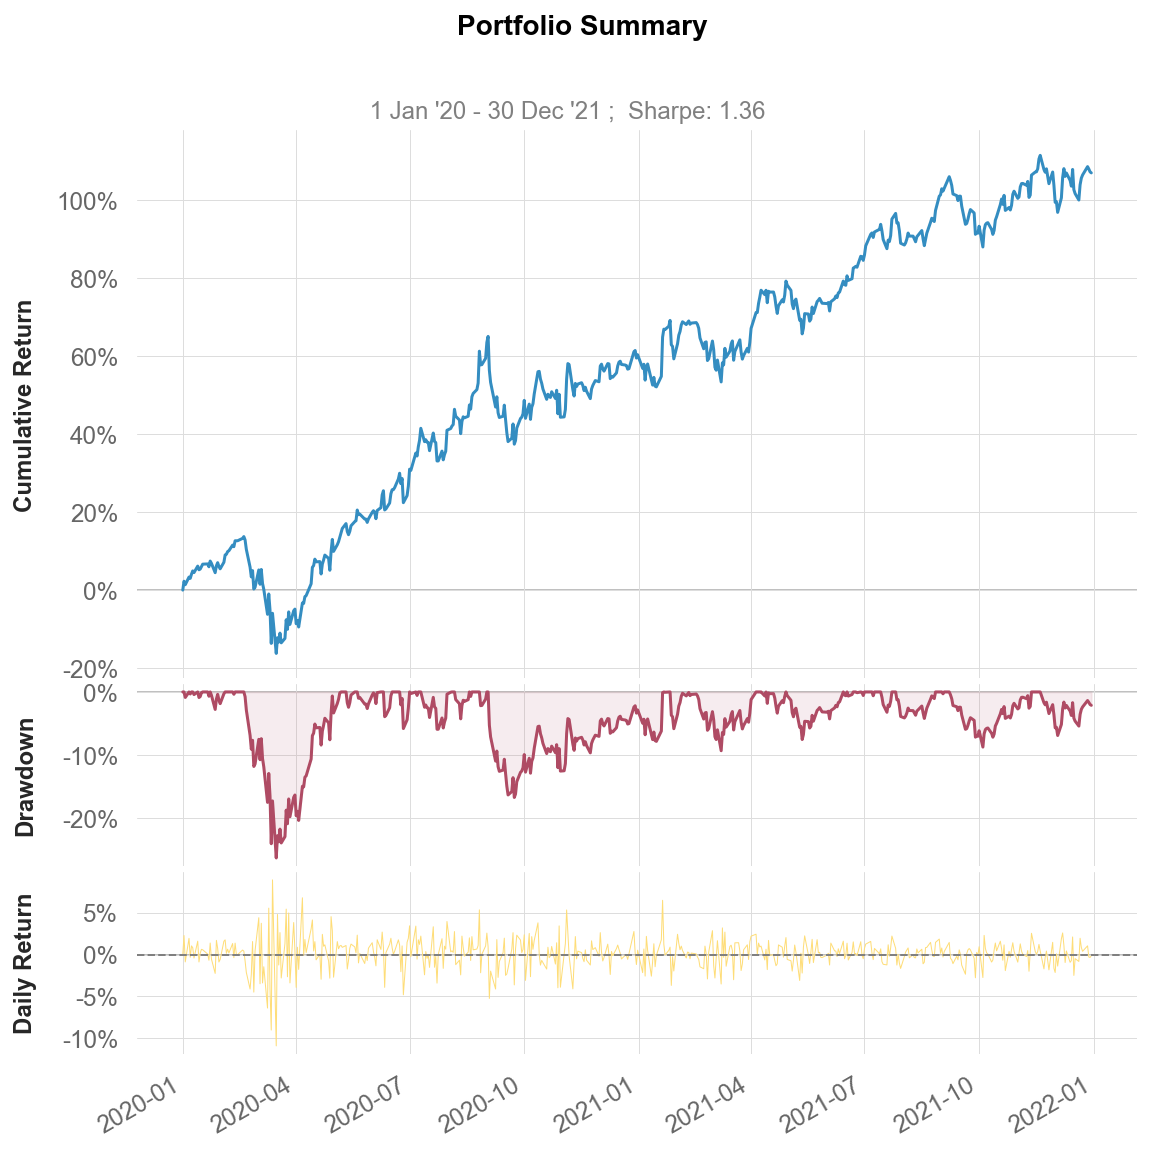

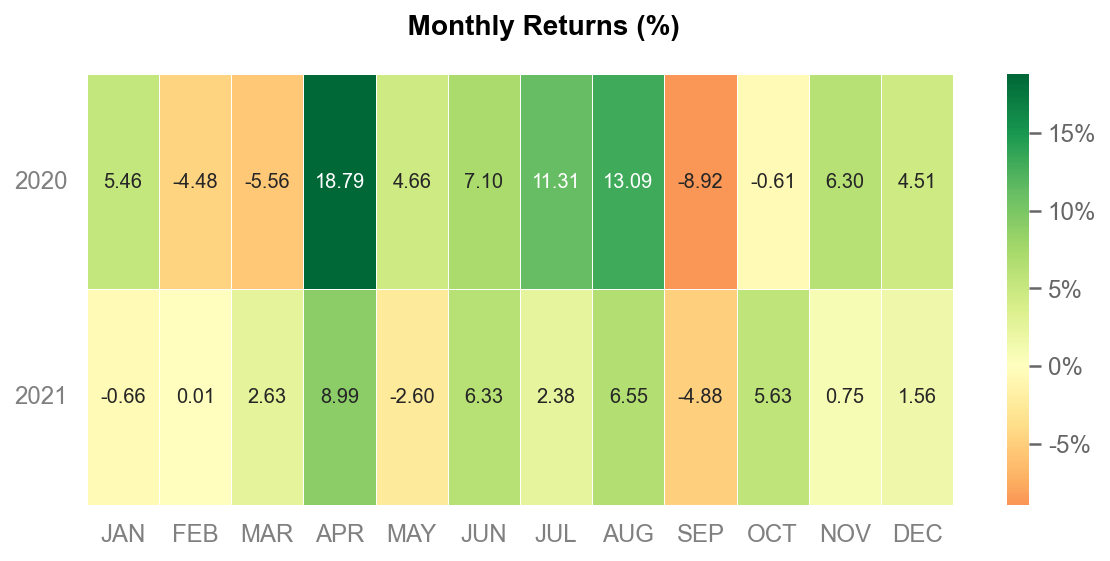

In [15]:
qs.reports.plots(portfolio_returns, benchmark="SPY", mode="basic", prepare_returns=False)
# qs.reports.plots(portfolio_returns, benchmark="SPY", mode="full", prepare_returns=False)

In [16]:
help(portfolio_returns.value_at_risk)

Help on method value_at_risk in module quantstats.stats:

value_at_risk(sigma=1, confidence=0.95, prepare_returns=True) method of pandas.core.series.Series instance
    Calculats the daily value-at-risk
    (variance-covariance calculation with confidence n)



## 11.2 Finding the efficient frontier using Monte Carlo simulations

### How to do it...

1. Import the libraries:

In [13]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:

In [14]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
ASSETS = ["META", "TSLA", "TWTR", "MSFT"]
ASSETS.sort()

n_assets = len(ASSETS)

3. Download the stock prices from Yahoo Finance:

In [15]:
prices_df = yf.download(ASSETS, 
                        start="2021-01-01", 
                        end="2021-12-31", 
                        adjusted=True)

[*********************100%***********************]  4 of 4 completed


In [16]:
prices_df.head()

Adj Close                                          Close  \
                  META        MSFT        TSLA       TWTR        META   
Date                                                                    
2020-12-31  273.160004  218.523514  235.223328  54.150002  273.160004   
2021-01-04  268.940002  213.876373  243.256668  54.529999  268.940002   
2021-01-05  270.970001  214.082687  245.036667  53.880001  270.970001   
2021-01-06  263.309998  208.531662  251.993332  53.259998  263.309998   
2021-01-07  268.739990  214.465836  272.013336  52.330002  268.739990   

                                                     High              ...  \
                  MSFT        TSLA       TWTR        META        MSFT  ...   
Date                                                                   ...   
2020-12-31  222.419998  235.223328  54.150002  277.089996  223.000000  ...   
2021-01-04  217.690002  243.256668  54.529999  275.000000  223.000000  ...   
2021-01-05  217.899994  245.036667  53.880001  272.399994  218.520004  ...   
2021-01-06  212.250000  251.993332  53.259998  267.750000  216.490005  ...   
2021-01-07  218.289993  272.013336  52.330002  271.609985  219.339996  ...   

                   Low                   Open                          \
                  TSLA       TWTR        META        MSFT        TSLA   
Date                                                                    
2020-12-31  230.373337  53.740002  272.000000  221.699997  233.330002   
2021-01-04  239.063339  53.580002  274.779999  222.529999  239.820007   
2021-01-05  239.733337  53.150002  268.290009  217.259995  241.220001   
2021-01-06  249.699997  52.570000  262.000000  212.169998  252.830002   
2021-01-07  258.399994  51.459999  265.899994  214.039993  259.209991   

                         Volume                                 
                 TWTR      META      MSFT       TSLA      TWTR  
Date                                                            
2020-12-31  54.240002  12900400  20942100  148949700   4832261  
2021-01-04  54.490002  15106100  37130100  145914600  12231560  
2021-01-05  53.410000   9871600  23823000   96735600   8317207  
2021-01-06  53.270000  24354100  35930700  134100000   9260008  
2021-01-07  52.220001  15789800  27694500  154496700  18967648  

[5 rows x 24 columns]

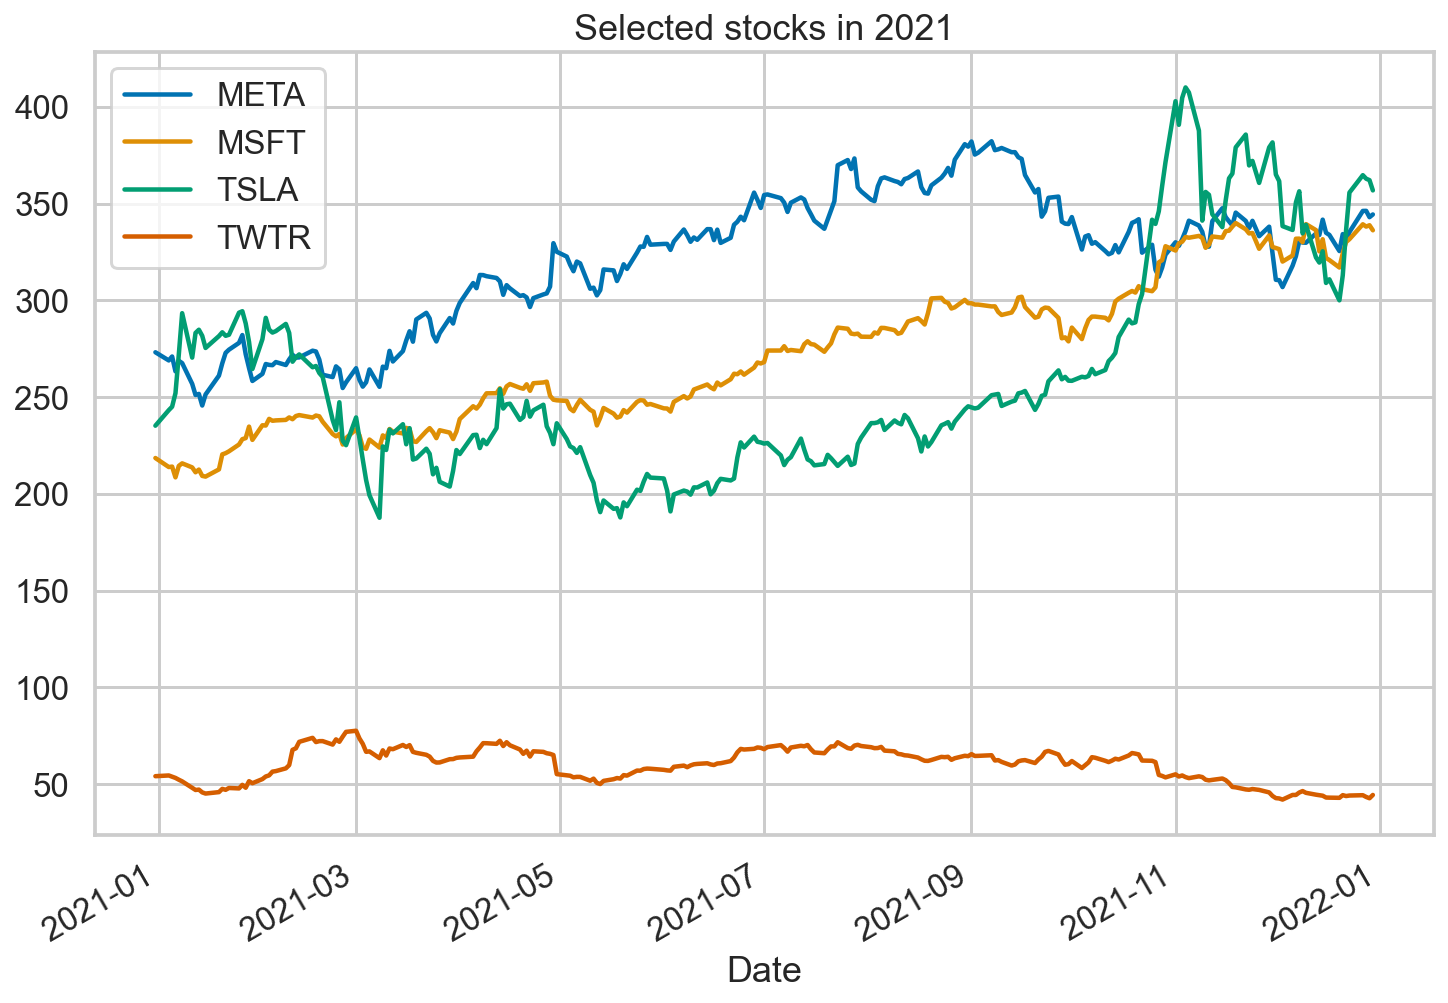

In [20]:
prices_df["Adj Close"].plot(title="Selected stocks in 2021");

4. Calculate annualized average returns and the corresponding standard deviation:

In [21]:
returns_df = prices_df["Adj Close"].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

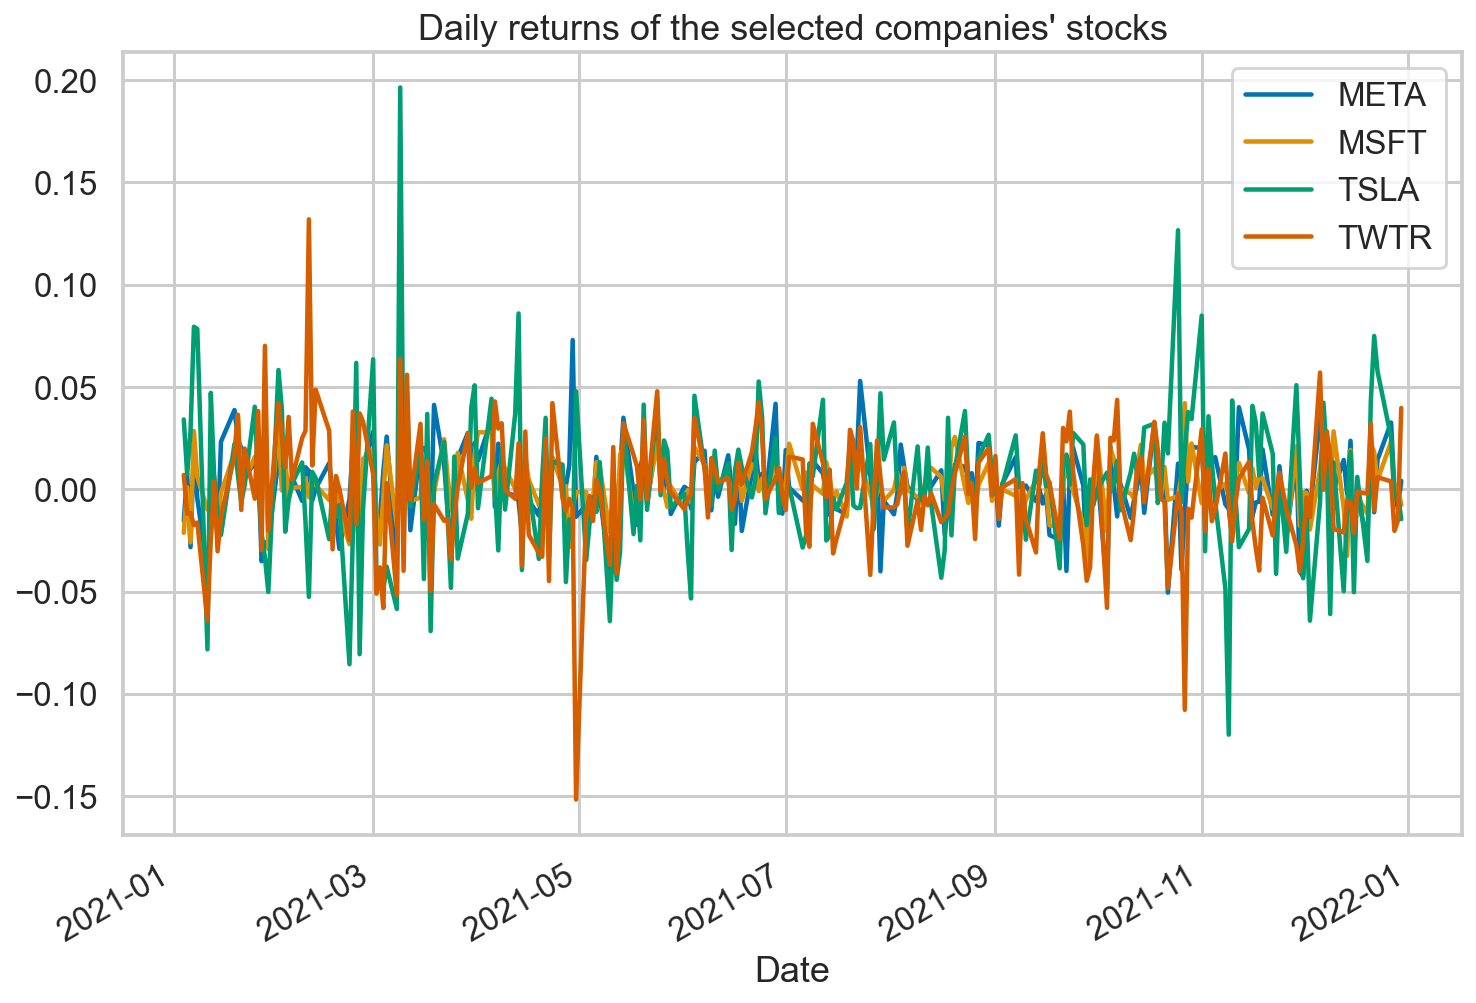

In [22]:
returns_df.plot(title="Daily returns of the selected companies' stocks");

5. Simulate random portfolio weights:

In [23]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

6. Calculate the portfolio metrics:

In [25]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    vol = np.sqrt(
        np.dot(weights[i].T, np.dot(cov_mat, weights[i]))
    )
    portf_vol.append(vol)
portf_vol = np.array(portf_vol)  

portf_sharpe_ratio = portf_rtns / portf_vol

7. Create a DataFrame containing all the data: 

In [26]:
portf_results_df = pd.DataFrame(
    {"returns": portf_rtns,
     "volatility": portf_vol,
     "sharpe_ratio": portf_sharpe_ratio}
)
portf_results_df

returns  volatility  sharpe_ratio
0      0.335464    0.266351      1.259480
1      0.049227    0.346262      0.142167
2      0.175372    0.267961      0.654471
3      0.291582    0.257783      1.131113
4      0.346867    0.264669      1.310569
...         ...         ...           ...
99995  0.442953    0.279346      1.585678
99996  0.145918    0.304849      0.478655
99997  0.419965    0.278450      1.508224
99998  0.277796    0.288633      0.962455
99999  0.353457    0.305080      1.158572

[100000 rows x 3 columns]

8. Locate the points creating the Efficient Frontier:

In [28]:
N_POINTS = 100

ef_rtn_list = []
ef_vol_list = []

possible_ef_rtns = np.linspace(
    portf_results_df["returns"].min(), 
    portf_results_df["returns"].max(), 
    N_POINTS
)
possible_ef_rtns = np.round(possible_ef_rtns, 2)    
portf_rtns = np.round(portf_rtns, 2)

for rtn in possible_ef_rtns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        matched_ind = np.where(portf_rtns == rtn)
        ef_vol_list.append(np.min(portf_vol[matched_ind]))

9. Plot the Efficient Frontier:

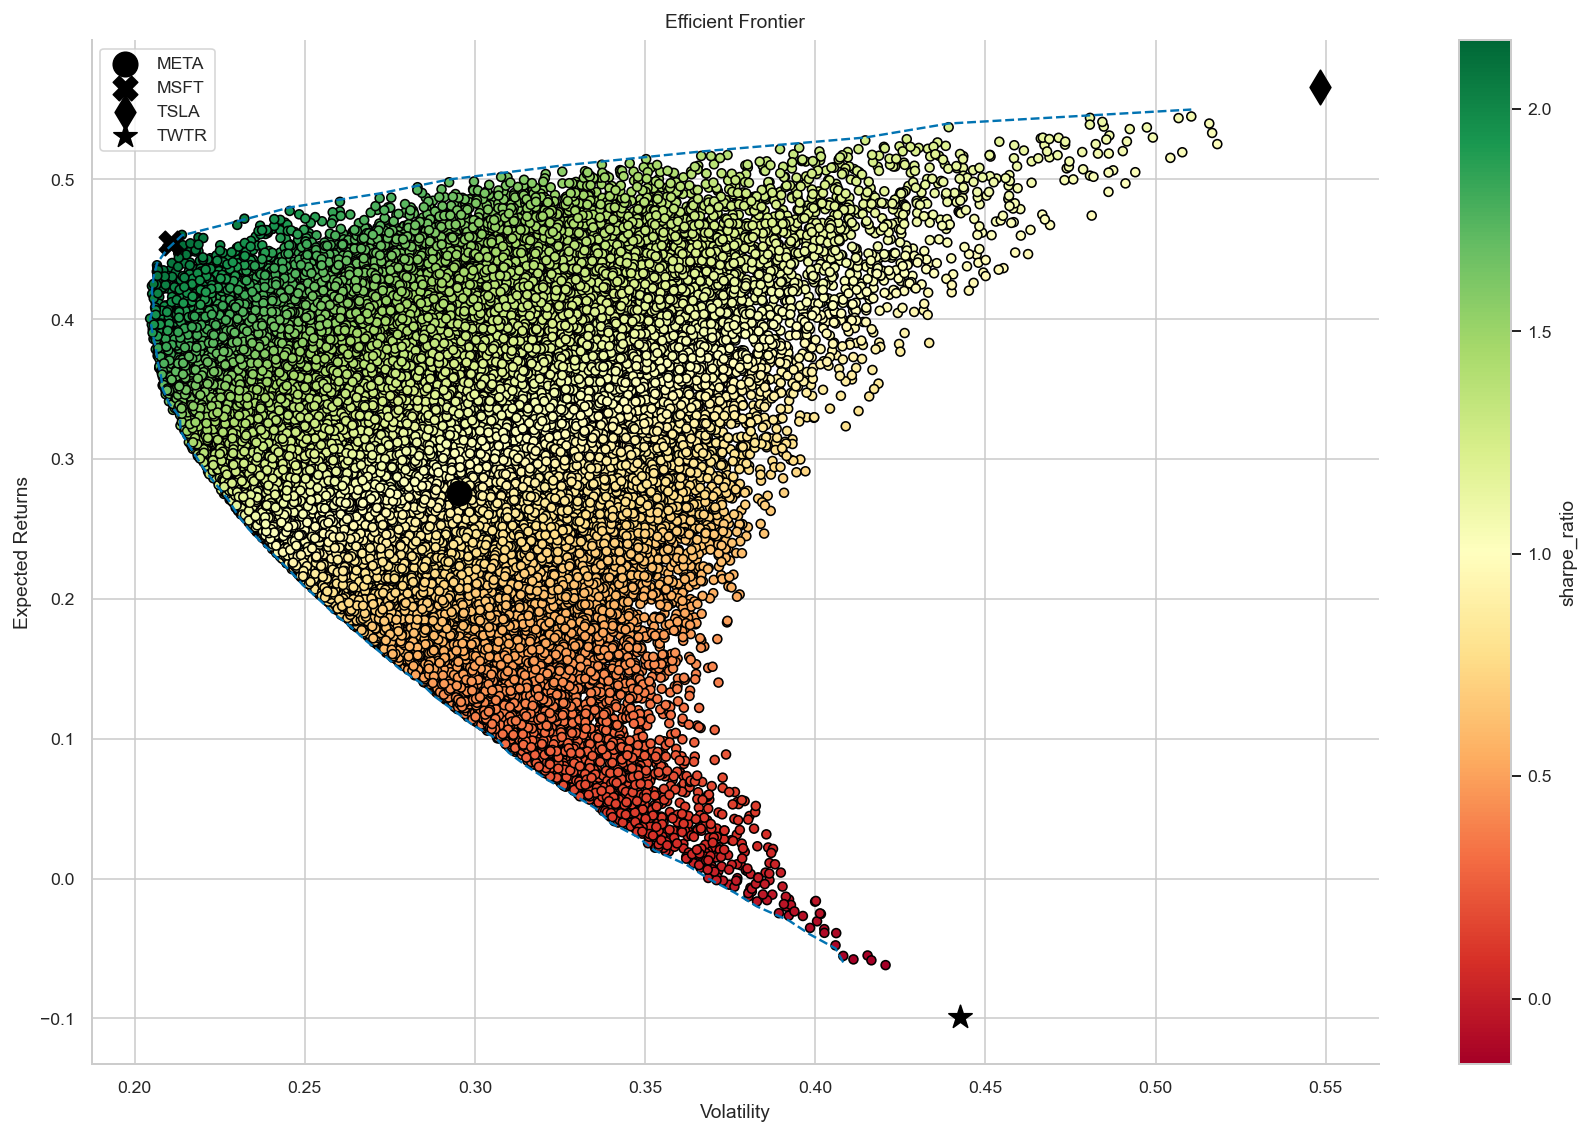

In [31]:
MARKERS = ["o", "X", "d", "*"]

with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")
    ax.plot(ef_vol_list, ef_rtn_list, "b--")
    for asset_index in range(n_assets):
        ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                   y=avg_returns[asset_index], 
                   marker=MARKERS[asset_index], 
                   s=150, color="black",
                   label=ASSETS[asset_index])
    ax.legend()

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_11_10", dpi=200)

### There's more

In [32]:
from chapter_11_utils import print_portfolio_summary

In [33]:
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"])
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df["volatility"])
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [34]:
print_portfolio_summary(max_sharpe_portf, 
                        weights[max_sharpe_ind], 
                        ASSETS, 
                        name="Maximum Sharpe Ratio")

Maximum Sharpe Ratio portfolio ----
Performance
returns: 45.14% volatility: 20.95% sharpe_ratio: 215.46% 
Weights
META: 2.60% MSFT: 95.17% TSLA: 2.04% TWTR: 0.19% 

In [35]:
print_portfolio_summary(min_vol_portf, 
                        weights[min_vol_ind], 
                        ASSETS, 
                        name="Minimum Volatility")

Minimum Volatility portfolio ----
Performance
returns: 40.05% volatility: 20.46% sharpe_ratio: 195.76% 
Weights
META: 17.35% MSFT: 78.16% TSLA: 0.23% TWTR: 4.26% 

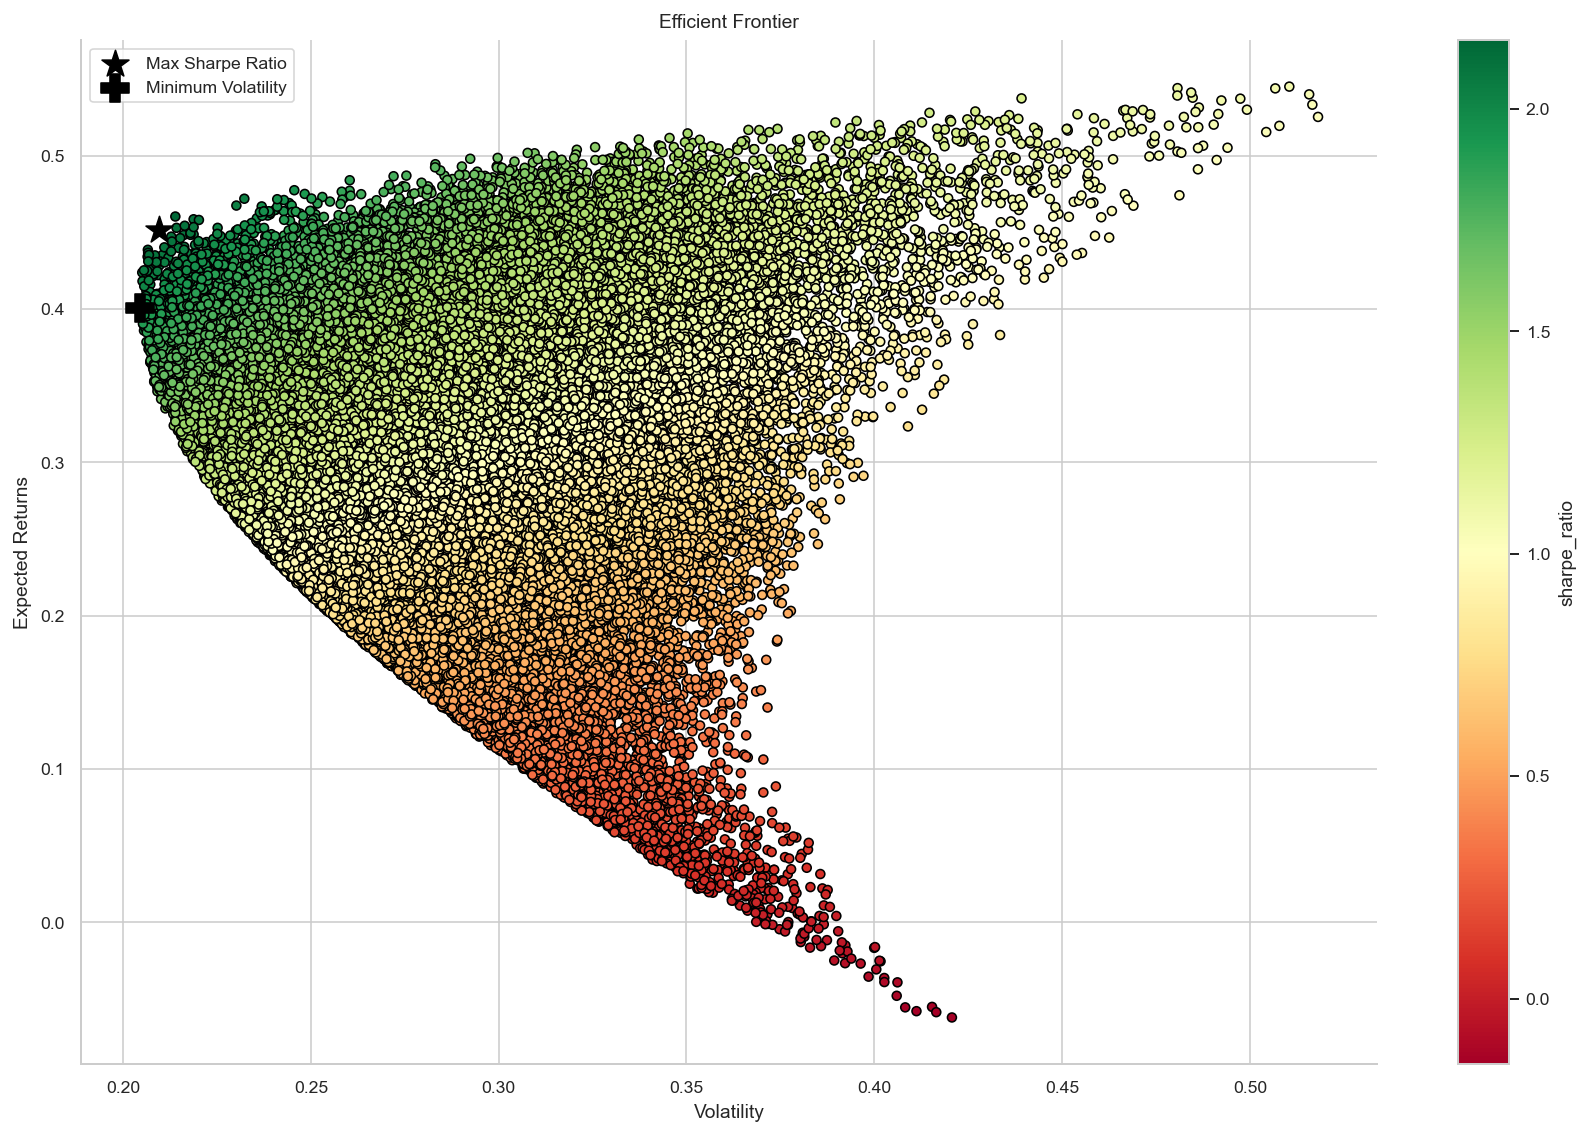

In [36]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.scatter(x=max_sharpe_portf.volatility, 
               y=max_sharpe_portf.returns, 
               c="black", marker="*", 
               s=200, label="Max Sharpe Ratio")
    ax.scatter(x=min_vol_portf.volatility, 
               y=min_vol_portf.returns, 
               c="black", marker="P", 
               s=200, label="Minimum Volatility")
    ax.set(xlabel="Volatility", ylabel="Expected Returns", 
           title="Efficient Frontier")
    ax.legend()

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_11_11", dpi=200)

## 11.3 Finding the efficient frontier using optimization with `scipy`

### Getting Ready

This recipe requires running all the code from the recipe *Finding the Efficient Frontier using Monte Carlo simulations*.

### How to do it...

1. Import the libraries:

In [37]:
import numpy as np
import scipy.optimize as sco
from chapter_11_utils import print_portfolio_summary

2. Define functions calculating portfolio returns and volatility:

In [38]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

3. Define the function calculating the efficient frontier:

In [39]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constr = (
            {"type": "eq", 
             "fun": lambda x: get_portf_rtn(x, avg_rtns) - ret},
            {"type": "eq", 
             "fun": lambda x: np.sum(x) - 1}
        )
        ef_portf = sco.minimize(get_portf_vol, 
                                initial_guess, 
                                args=args, method="SLSQP", 
                                constraints=constr,
                                bounds=bounds)
        efficient_portfolios.append(ef_portf)
    
    return efficient_portfolios

4. Define the considered range of expected portfolio returns:

In [40]:
rtns_range = np.linspace(-0.1, 0.55, 200)

5. Calculate the Efficient Frontier:

In [41]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

6. Extract the volatilities of the efficient portfolios:

In [42]:
vols_range = [x["fun"] for x in efficient_portfolios]

7. Plot the calculated Efficient Frontier, together with the simulated portfolios:

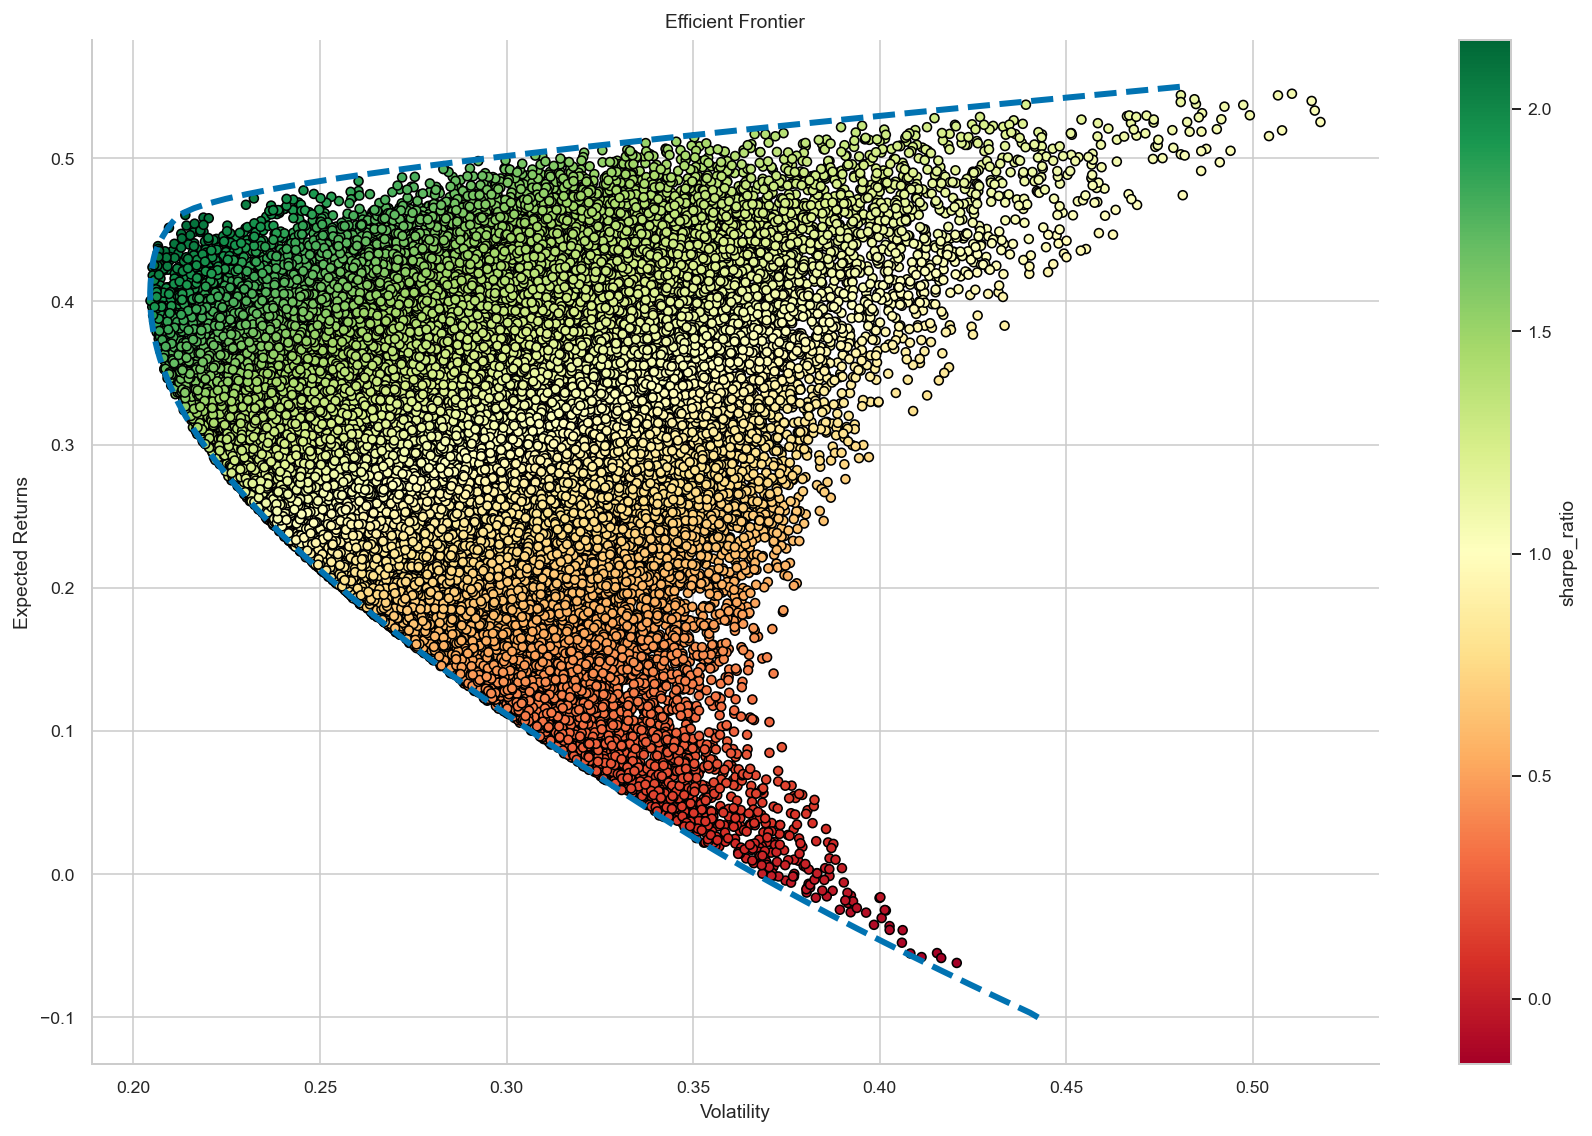

In [43]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.plot(vols_range, rtns_range, "b--", linewidth=3)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_11_12", dpi=200)

8. Identify the minimum volatility portfolio:

In [26]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]["fun"]

min_vol_portf = {
    "Return": min_vol_portf_rtn,
    "Volatility": min_vol_portf_vol,
    "Sharpe Ratio": (min_vol_portf_rtn / min_vol_portf_vol)
}

min_vol_portf

{'Return': 0.4030150753768844,
 'Volatility': 0.20447691908899487,
 'Sharpe Ratio': 1.9709563170867193}

9. Print the performance summary:

In [27]:
print_portfolio_summary(min_vol_portf, 
                        efficient_portfolios[min_vol_ind]["x"], 
                        ASSETS, 
                        name="Minimum Volatility")

Minimum Volatility portfolio ----
Performance
Return: 40.30% Volatility: 20.45% Sharpe Ratio: 197.10% 
Weights
FB: 15.98% MSFT: 79.82% TSLA: 0.00% TWTR: 4.20% 

### There's more

1. Define the new objective function (negative Sharpe ratio): 

In [28]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (
        (portf_returns - rf_rate) / portf_volatility
    )
    return -portf_sharpe_ratio

2. Find the optimized portfolio:

In [29]:
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({"type": "eq", 
                "fun": lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method="SLSQP", 
                                bounds=bounds, 
                                constraints=constraints)

3. Extract information about the maximum Sharpe Ratio portfolio:

In [30]:
max_sharpe_portf_w = max_sharpe_portf["x"]
max_sharpe_portf = {
    "Return": get_portf_rtn(max_sharpe_portf_w, avg_returns),
    "Volatility": get_portf_vol(max_sharpe_portf_w, 
                                avg_returns, 
                                cov_mat),
    "Sharpe Ratio": -max_sharpe_portf["fun"]
}
max_sharpe_portf

{'Return': 0.4590320167096378,
 'Volatility': 0.21173007867600227,
 'Sharpe Ratio': 2.168005696592909}

4. Print performance summary:

In [31]:
print_portfolio_summary(max_sharpe_portf, 
                        max_sharpe_portf_w, 
                        ASSETS, 
                        name="Maximum Sharpe Ratio")

Maximum Sharpe Ratio portfolio ----
Performance
Return: 45.90% Volatility: 21.17% Sharpe Ratio: 216.80% 
Weights
FB: 0.00% MSFT: 96.27% TSLA: 3.73% TWTR: 0.00% 

## 11.4 Finding the efficient frontier using convex optimization with `cvxpy`

### Getting Ready

This recipe requires running all the code from the previous recipes:
* *Finding the Efficient Frontier using Monte Carlo simulations*
* *Finding the Efficient Frontier using optimization with `scipy`*

### How to do it...

1. Import the libraries:

In [44]:
import cvxpy as cp

2. Convert the annualized average returns and the covariance matrix to `numpy` arrays:

In [45]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

3. Set up the optimization problem:

In [46]:
weights = cp.Variable(n_assets)
gamma_par = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(
    portf_rtn_cvx - gamma_par * portf_vol_cvx
)
problem = cp.Problem(
    objective_function, 
    [cp.sum(weights) == 1, weights >= 0]
)

4. Calculate the Efficient Frontier:

In [47]:
N_POINTS = 25
portf_rtn_cvx_ef = []
portf_vol_cvx_ef = []
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for gamma in gamma_range:
    gamma_par.value = gamma
    problem.solve()
    portf_vol_cvx_ef.append(cp.sqrt(portf_vol_cvx).value)
    portf_rtn_cvx_ef.append(portf_rtn_cvx.value)
    weights_ef.append(weights.value)

5. Plot the allocation for different values of the risk-aversion parameter:

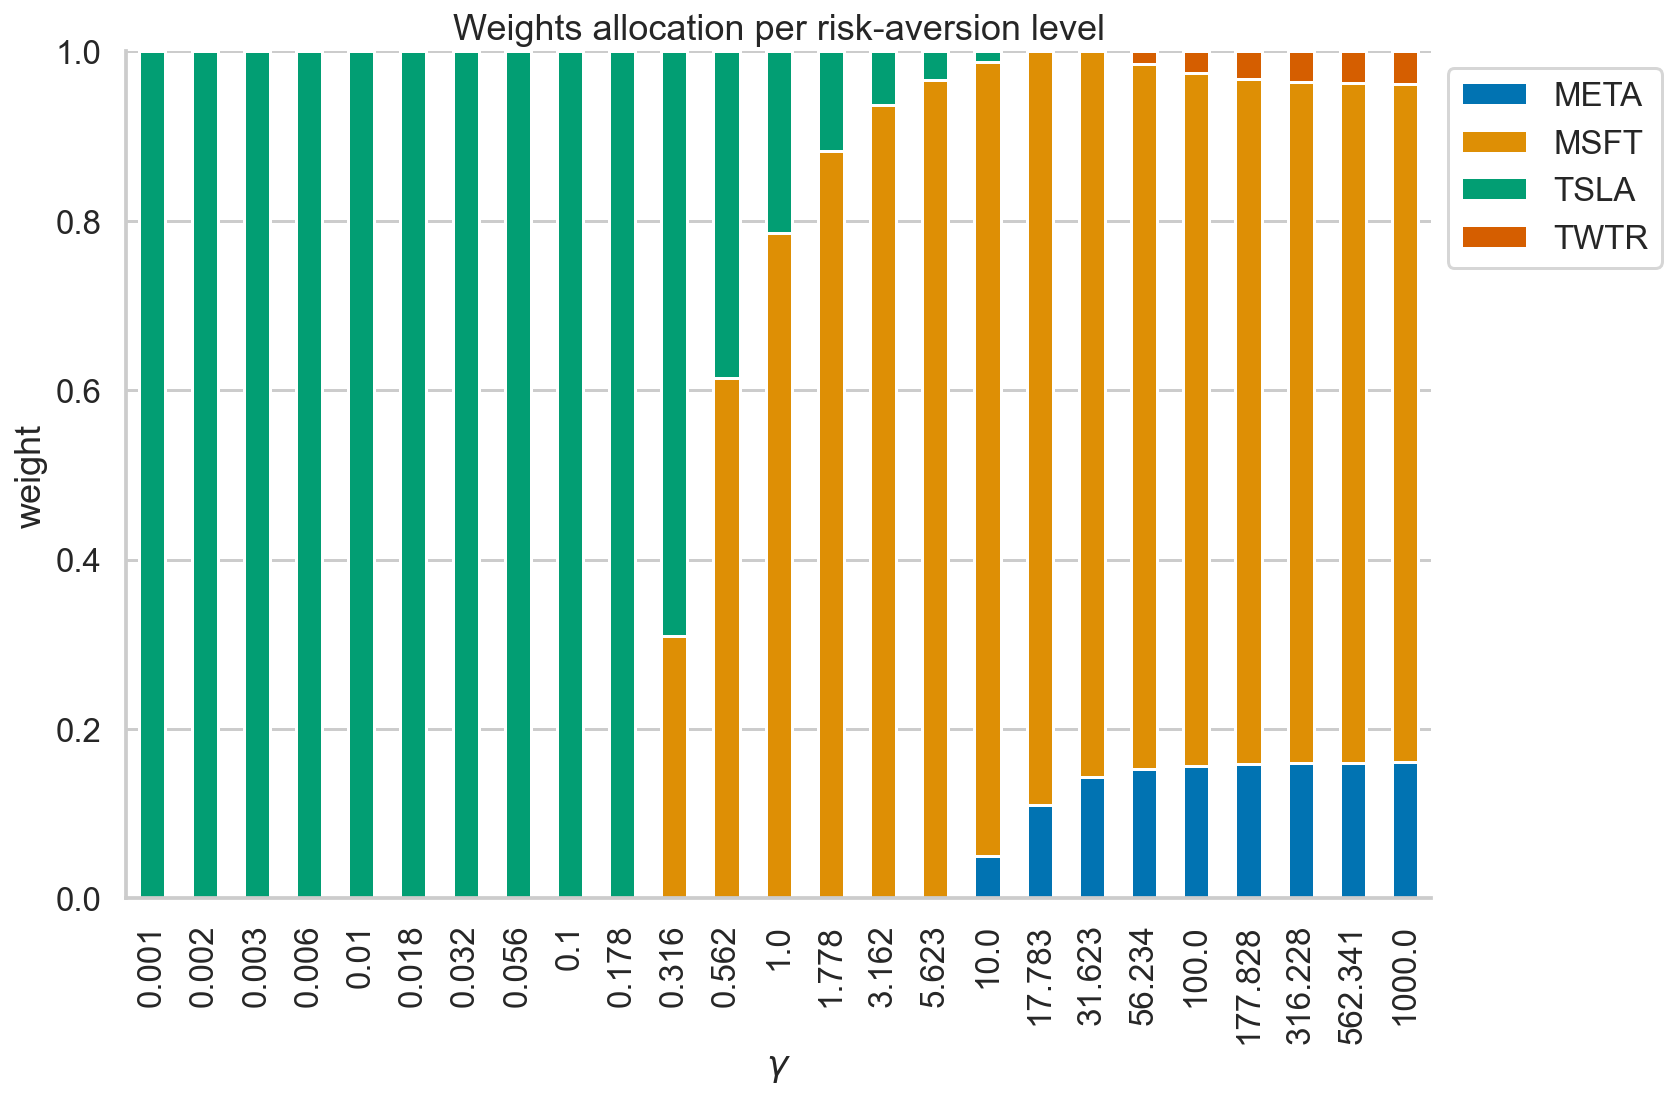

In [48]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=ASSETS, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind="bar", stacked=True) 
ax.set(title="Weights allocation per risk-aversion level",
       xlabel=r"$\gamma$", 
       ylabel="weight")
ax.legend(bbox_to_anchor=(1,1))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_13", dpi=200)

6. Plot the Efficient Frontier, together with the individual assets:

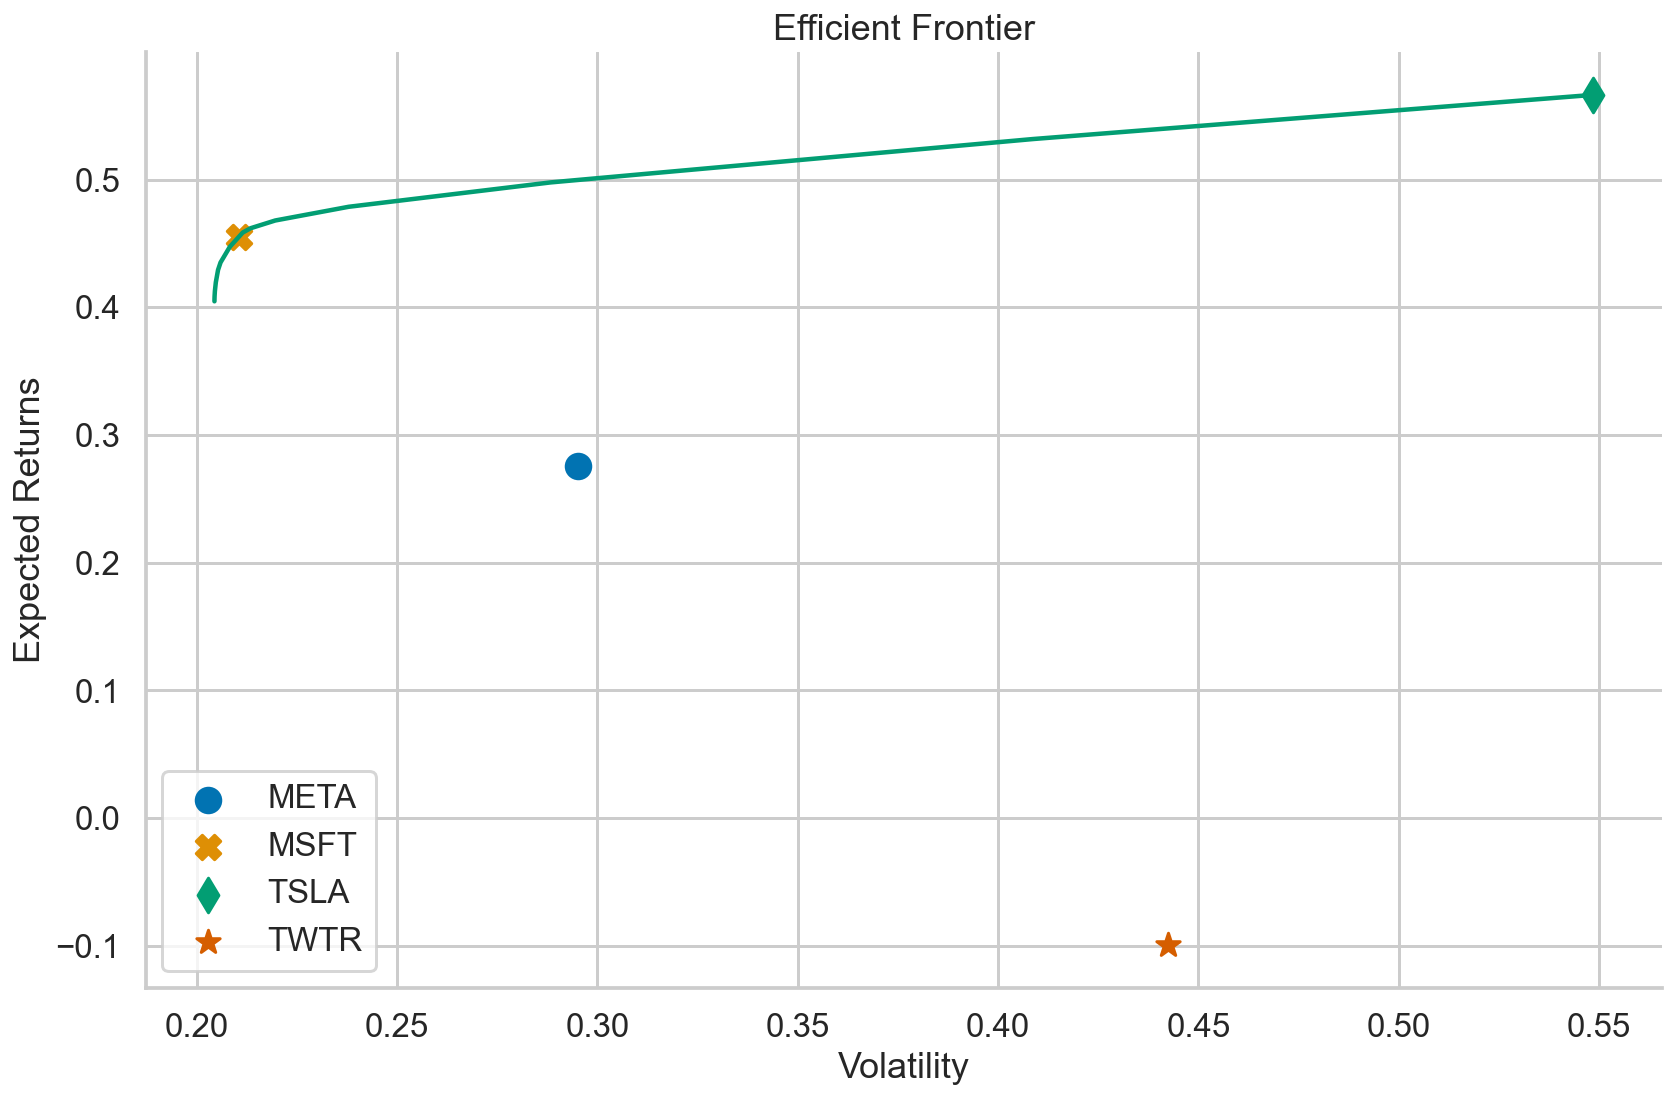

In [49]:
#MARKERS = ["o", "X", "d", "*"]

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, "g-")
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKERS[asset_index], 
                 label=ASSETS[asset_index],
                 s=150)
ax.set(title="Efficient Frontier",
       xlabel="Volatility", 
       ylabel="Expected Returns")
ax.legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_14", dpi=200)

### There's more

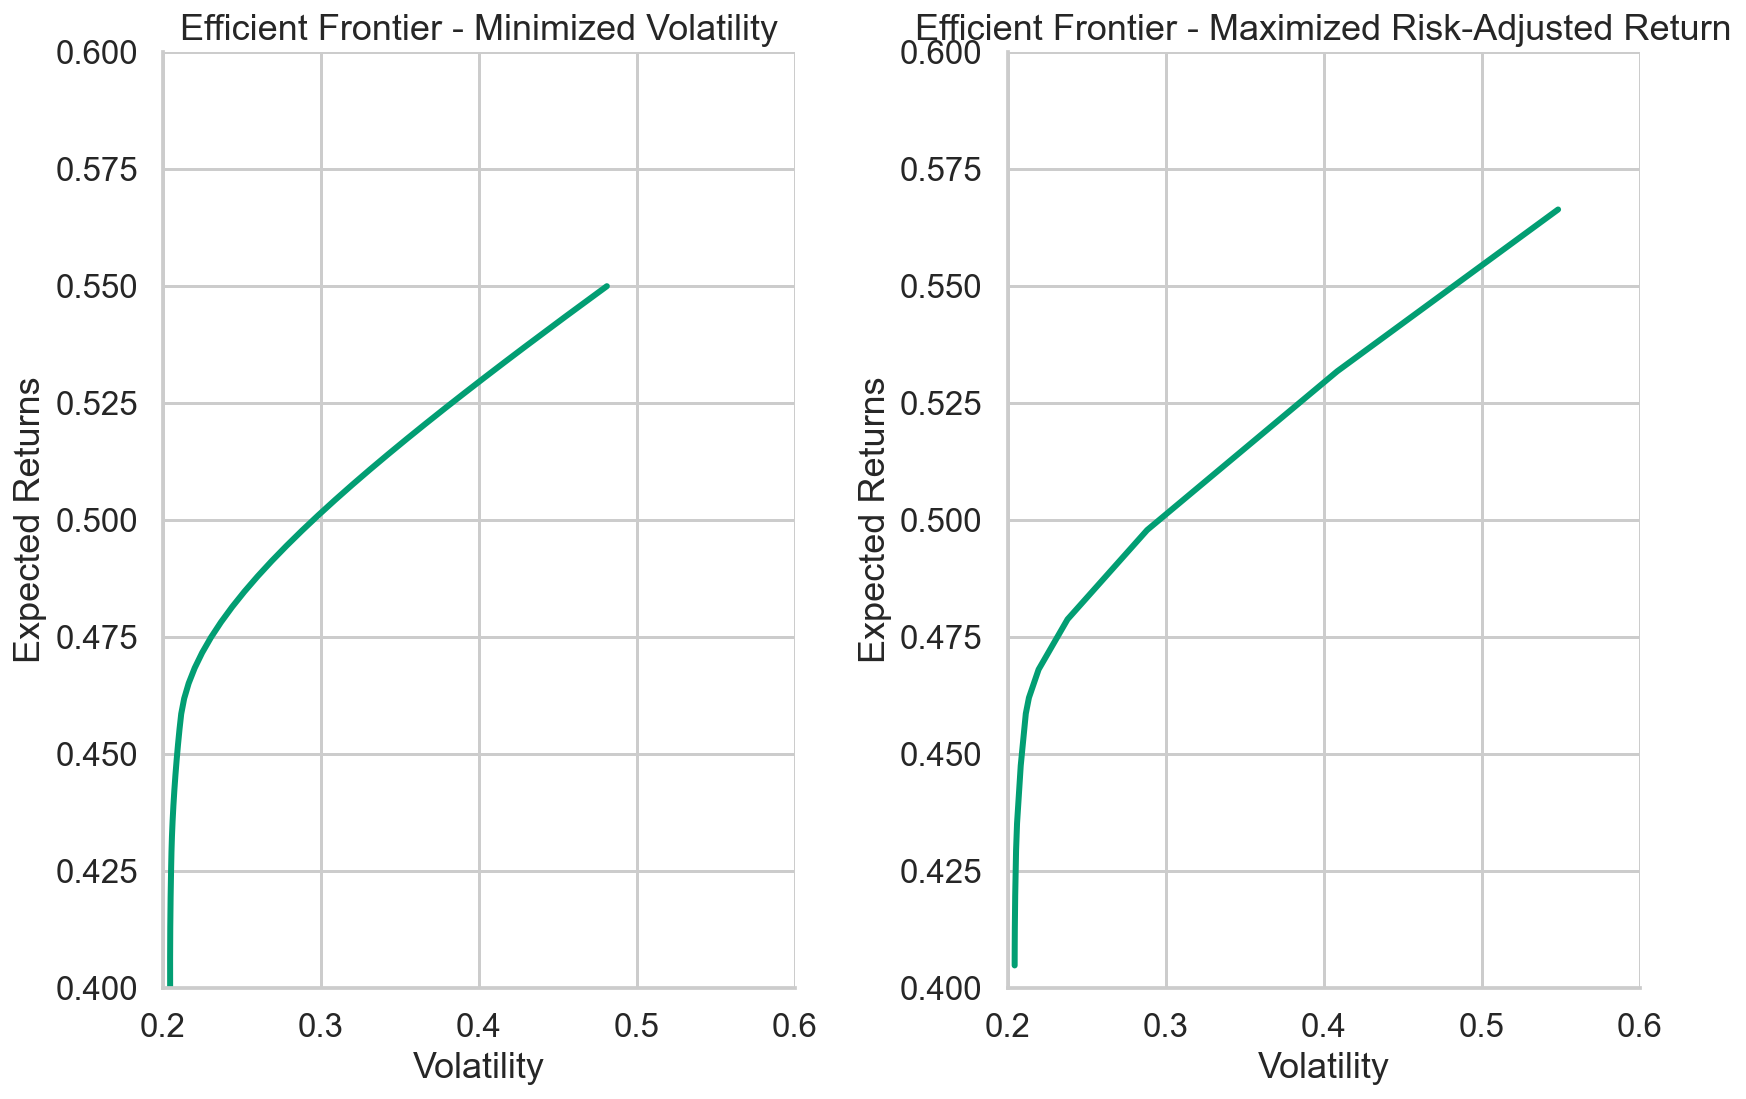

In [52]:
x_lim = [0.2, 0.6]
y_lim = [0.4, 0.6]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, "g-", linewidth=3)
ax[0].set(title="Efficient Frontier - Minimized Volatility",
          xlabel="Volatility", 
          ylabel="Expected Returns",
          xlim=x_lim, 
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, "g-", linewidth=3)
ax[1].set(title="Efficient Frontier - Maximized Risk-Adjusted Return",
          xlabel="Volatility", 
          ylabel="Expected Returns",
          xlim=x_lim, 
          ylim=y_lim)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_15", dpi=200)

In [53]:
max_leverage = cp.Parameter()
prob_with_leverage = cp.Problem(objective_function, 
                                [cp.sum(weights) == 1, 
                                cp.norm(weights, 1) <= max_leverage])

In [54]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l = np.zeros((N_POINTS, len_leverage))
portf_rtn_l = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma_par.value = gamma_range[gamma_ind]
        prob_with_leverage.solve()
        portf_vol_l[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value
        

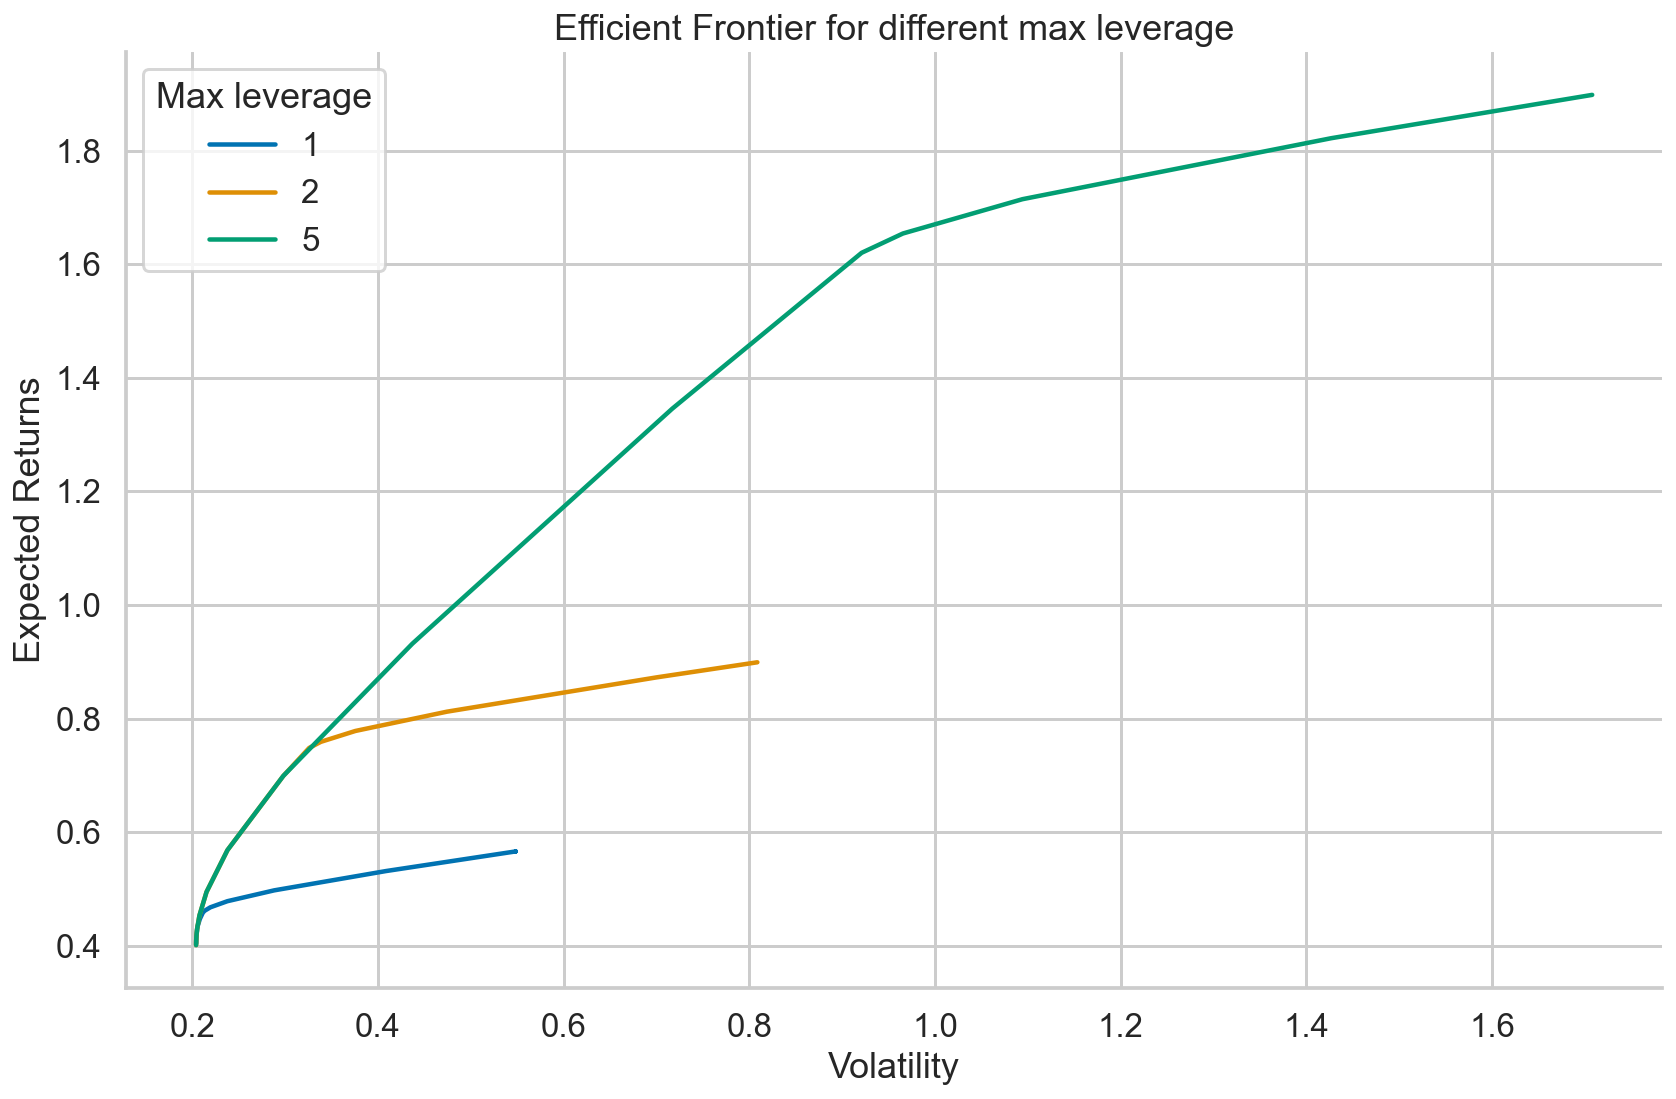

In [55]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l[:, leverage_index], 
             portf_rtn_l[:, leverage_index], 
             label=f"{leverage}")

ax.set(title="Efficient Frontier for different max leverage",
       xlabel="Volatility", 
       ylabel="Expected Returns")
ax.legend(title="Max leverage")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_16", dpi=200)

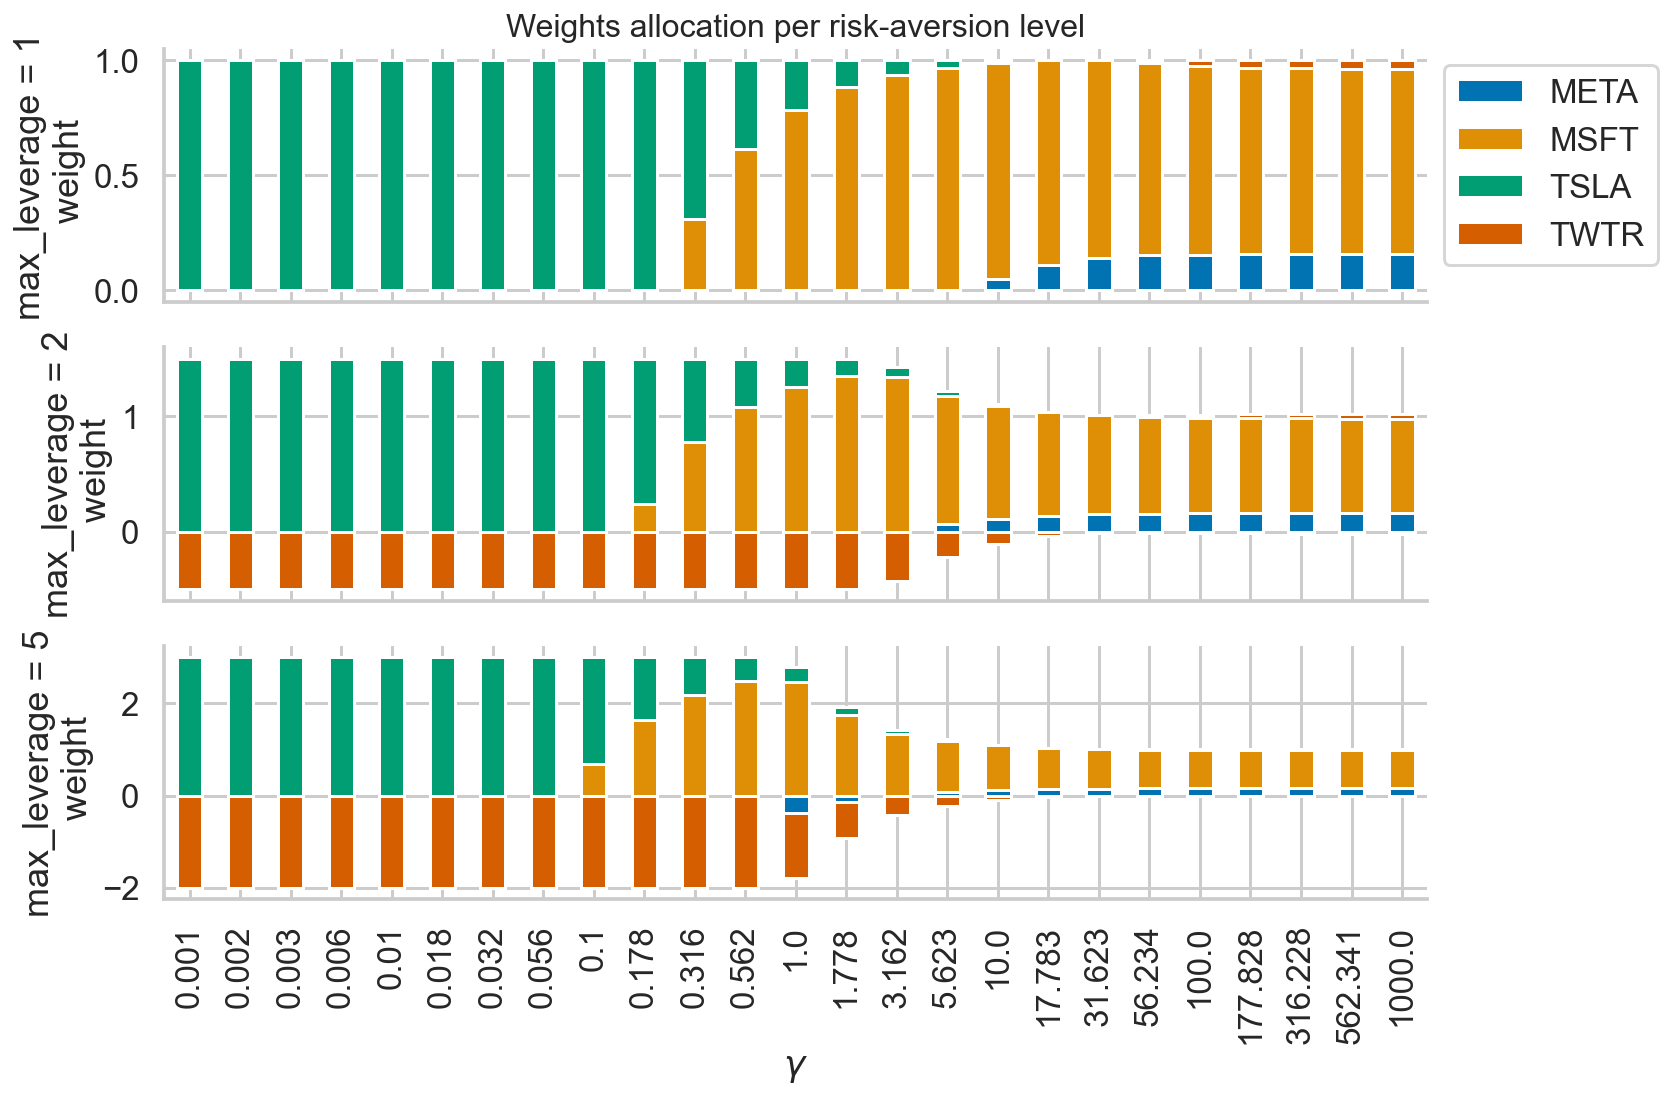

In [56]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=ASSETS, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind="bar", 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(
        ylabel=(f"max_leverage = {LEVERAGE_RANGE[ax_index]}" 
                "\n weight")
    )

    
ax[len_leverage - 1].set(xlabel=r"$\gamma$")
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title("Weights allocation per risk-aversion level",
                fontsize=16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_17", dpi=200)

## 11.5 Finding the optimal portfolio with Hierarchical Risk Parity

### How to do it...

1. Import the libraries:


In [57]:
import yfinance as yf
import pandas as pd
from pypfopt.expected_returns import returns_from_prices
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.discrete_allocation import (
    DiscreteAllocation, get_latest_prices
)
from pypfopt import plotting


2. Download the stock prices of the 10 biggest US tech companies:

In [58]:
ASSETS = ["AAPL", "MSFT", "AMZN", "GOOG", "META", 
          "V", "NVDA", "MA", "PYPL", "NFLX"]

prices_df = yf.download(ASSETS, 
                        start="2021-01-01", 
                        end="2021-12-31", 
                        adjusted=True)
prices_df = prices_df["Adj Close"]
prices_df

[*********************100%***********************]  10 of 10 completed


AAPL        AMZN        GOOG          MA        META  \
Date                                                                     
2020-12-31  131.116013  162.846497   87.594002  353.128632  273.160004   
2021-01-04  127.874954  159.331497   86.412003  347.736877  268.940002   
2021-01-05  129.455948  160.925507   87.045998  343.710297  270.970001   
2021-01-06  125.098282  156.919006   86.764503  343.838898  263.309998   
2021-01-07  129.367035  158.108002   89.362503  346.562988  268.739990   
...                ...         ...         ...         ...         ...   
2021-12-23  175.262802  171.068497  147.142502  358.479675  335.239990   
2021-12-27  179.289444  169.669495  148.063995  358.211243  346.179993   
2021-12-28  178.255447  170.660995  146.447998  358.678528  346.220001   
2021-12-29  178.344925  169.201004  146.504501  359.185516  342.940002   
2021-12-30  177.171722  168.644501  146.002502  358.887268  344.359985   

                  MSFT        NFLX        NVDA        PYPL           V  
Date                                                                    
2020-12-31  218.523499  540.729980  130.314224  234.199997  215.762482  
2021-01-04  213.876358  522.859985  130.898163  231.919998  214.805634  
2021-01-05  214.082687  520.799988  133.805405  234.910004  211.599731  
2021-01-06  208.531662  500.489990  125.917175  226.830002  209.735382  
2021-01-07  214.465851  508.890015  133.199005  235.039993  210.909241  
...                ...         ...         ...         ...         ...  
2021-12-23  331.583038  614.090027  296.123077  192.009995  214.993683  
2021-12-27  339.270996  613.119995  309.160919  192.009995  215.996109  
2021-12-28  338.082092  610.710022  302.936707  190.100006  216.412979  
2021-12-29  338.775635  610.539978  299.729736  189.970001  216.532059  
2021-12-30  336.170044  612.090027  295.583588  191.880005  216.234299  

[252 rows x 10 columns]

3. Calculate the returns from prices:

In [59]:
rtn_df = returns_from_prices(prices_df)

4. Find the optimal allocation using Hierarchical Risk Parity:

In [60]:
hrp = HRPOpt(returns=rtn_df)
hrp.optimize()

OrderedDict([('AAPL', 0.1299168847564764),
             ('AMZN', 0.1560043712983541),
             ('GOOG', 0.0853154008887566),
             ('MA', 0.10027764919715909),
             ('META', 0.08133802700196043),
             ('MSFT', 0.10830003707042941),
             ('NFLX', 0.10164040950196232),
             ('NVDA', 0.04465861806067247),
             ('PYPL', 0.05326361752247518),
             ('V', 0.13928498470175404)])

5. Display the (cleaned) weights:

In [61]:
weights = hrp.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.12992), ('AMZN', 0.156), ('GOOG', 0.08532), ('MA', 0.10028), ('META', 0.08134), ('MSFT', 0.1083), ('NFLX', 0.10164), ('NVDA', 0.04466), ('PYPL', 0.05326), ('V', 0.13928)])


We can create a simple pie chart to visualize the optimized portfolio weights:

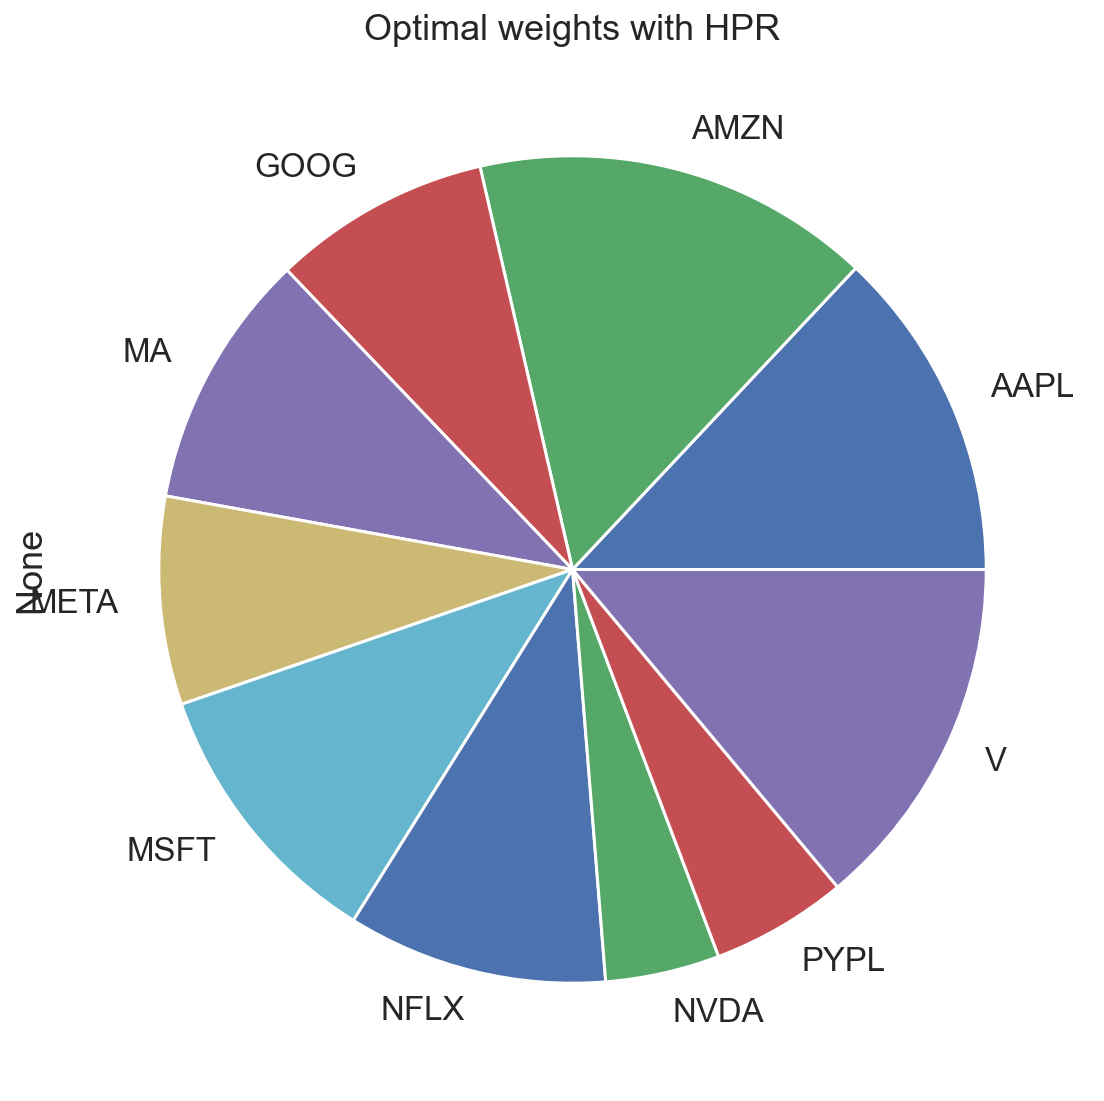

In [64]:
pd.Series(weights).plot(kind="pie",
                        title="Optimal weights with HPR");

sns.despine()
plt.tight_layout()

6. Calculate the portfolio performance:

In [65]:
hrp.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 23.3%
Annual volatility: 19.2%
Sharpe Ratio: 1.21


7. Visualize the hierarchical clustering used for finding the portfolio weights:

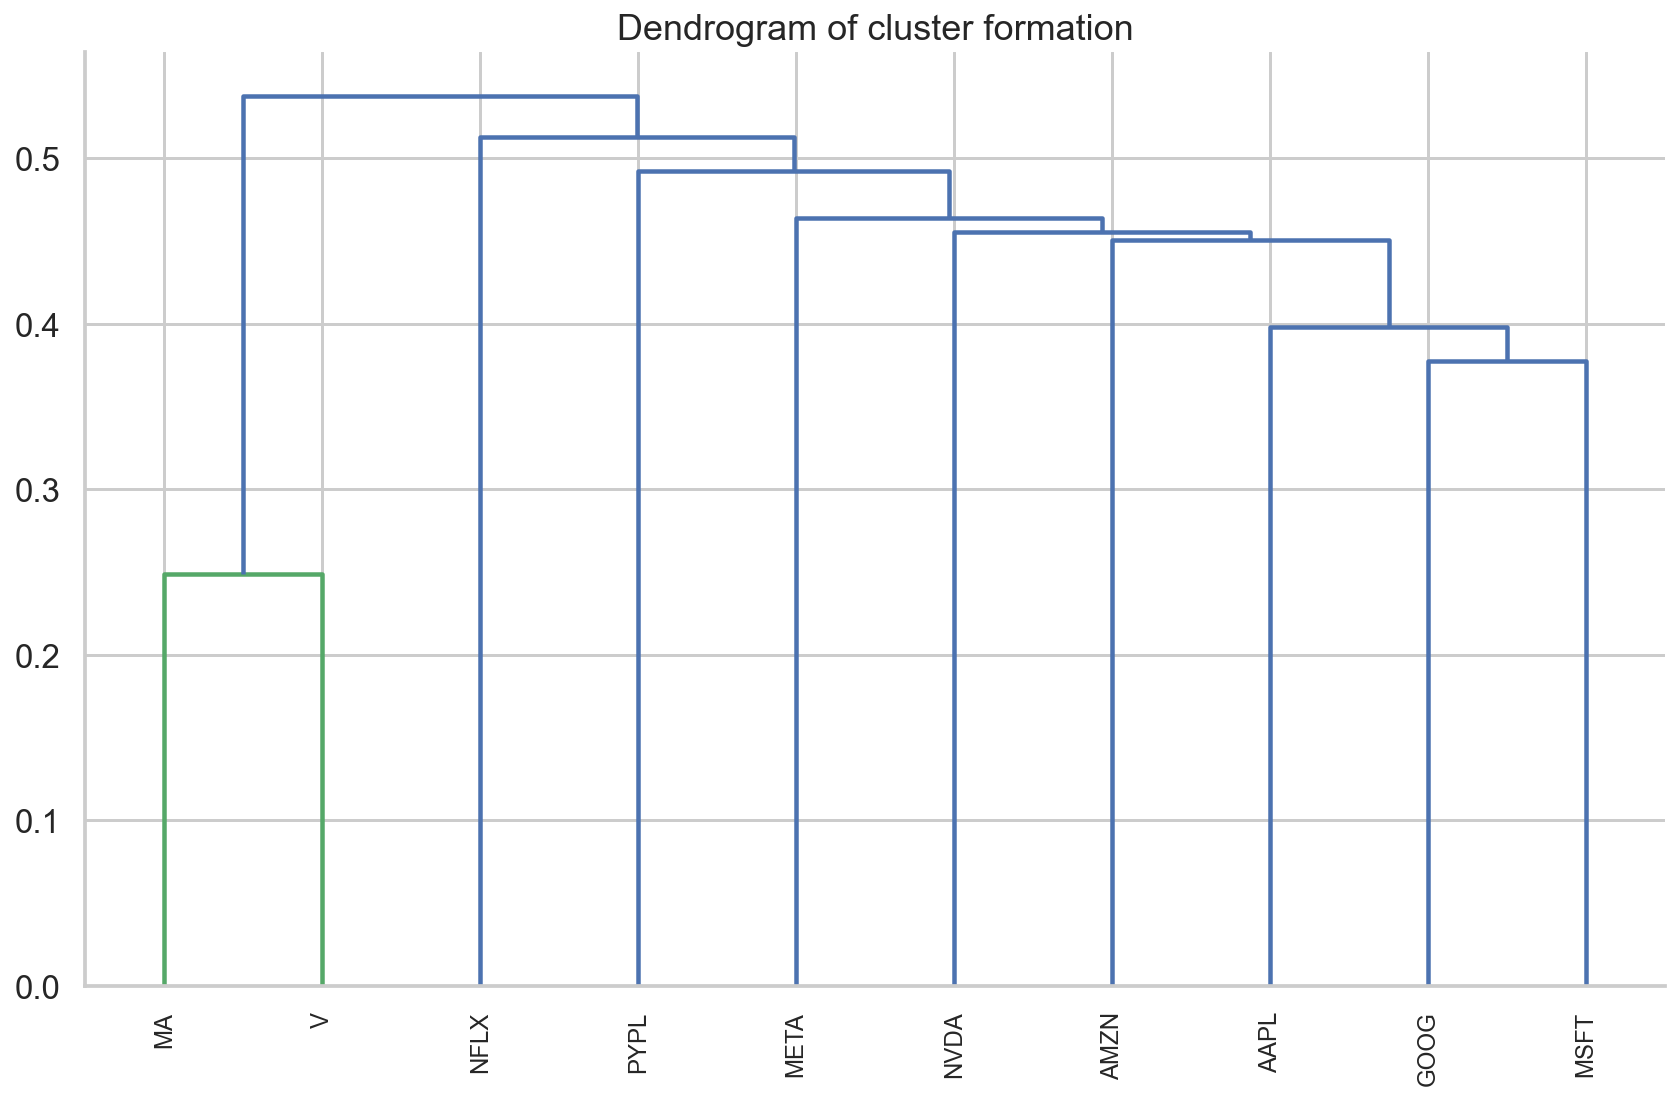

In [67]:
fig, ax = plt.subplots()
plotting.plot_dendrogram(hrp, ax=ax) 
ax.set_title("Dendrogram of cluster formation")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_18", dpi=200)

8. Find the number of stocks to buy using 50,000 USD:

In [68]:
latest_prices = get_latest_prices(prices_df)
allocation_finder = DiscreteAllocation(weights, 
                                       latest_prices, 
                                       total_portfolio_value=50000)
allocation, leftover = allocation_finder.lp_portfolio()
print(allocation)
print(leftover)

{'AAPL': 37, 'AMZN': 46, 'GOOG': 29, 'MA': 14, 'META': 12, 'MSFT': 16, 'NFLX': 8, 'NVDA': 8, 'PYPL': 14, 'V': 32}
50.257843017578125


In [69]:
# an alternative allocation using the greedy iterative algorithm
allocation, leftover = allocation_finder.greedy_portfolio()
print(allocation)
print(leftover)

{'AMZN': 46, 'V': 32, 'AAPL': 37, 'MSFT': 16, 'NFLX': 8, 'MA': 14, 'GOOG': 29, 'META': 12, 'PYPL': 14, 'NVDA': 8}
50.257843017578125


### There's more

1. Import the libraries:

In [70]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier

2. Get the expected returns and the covariance matrix:

In [71]:
mu = mean_historical_return(prices_df)
S = CovarianceShrinkage(prices_df).ledoit_wolf()

3. Find and plot the Efficient Frontier:

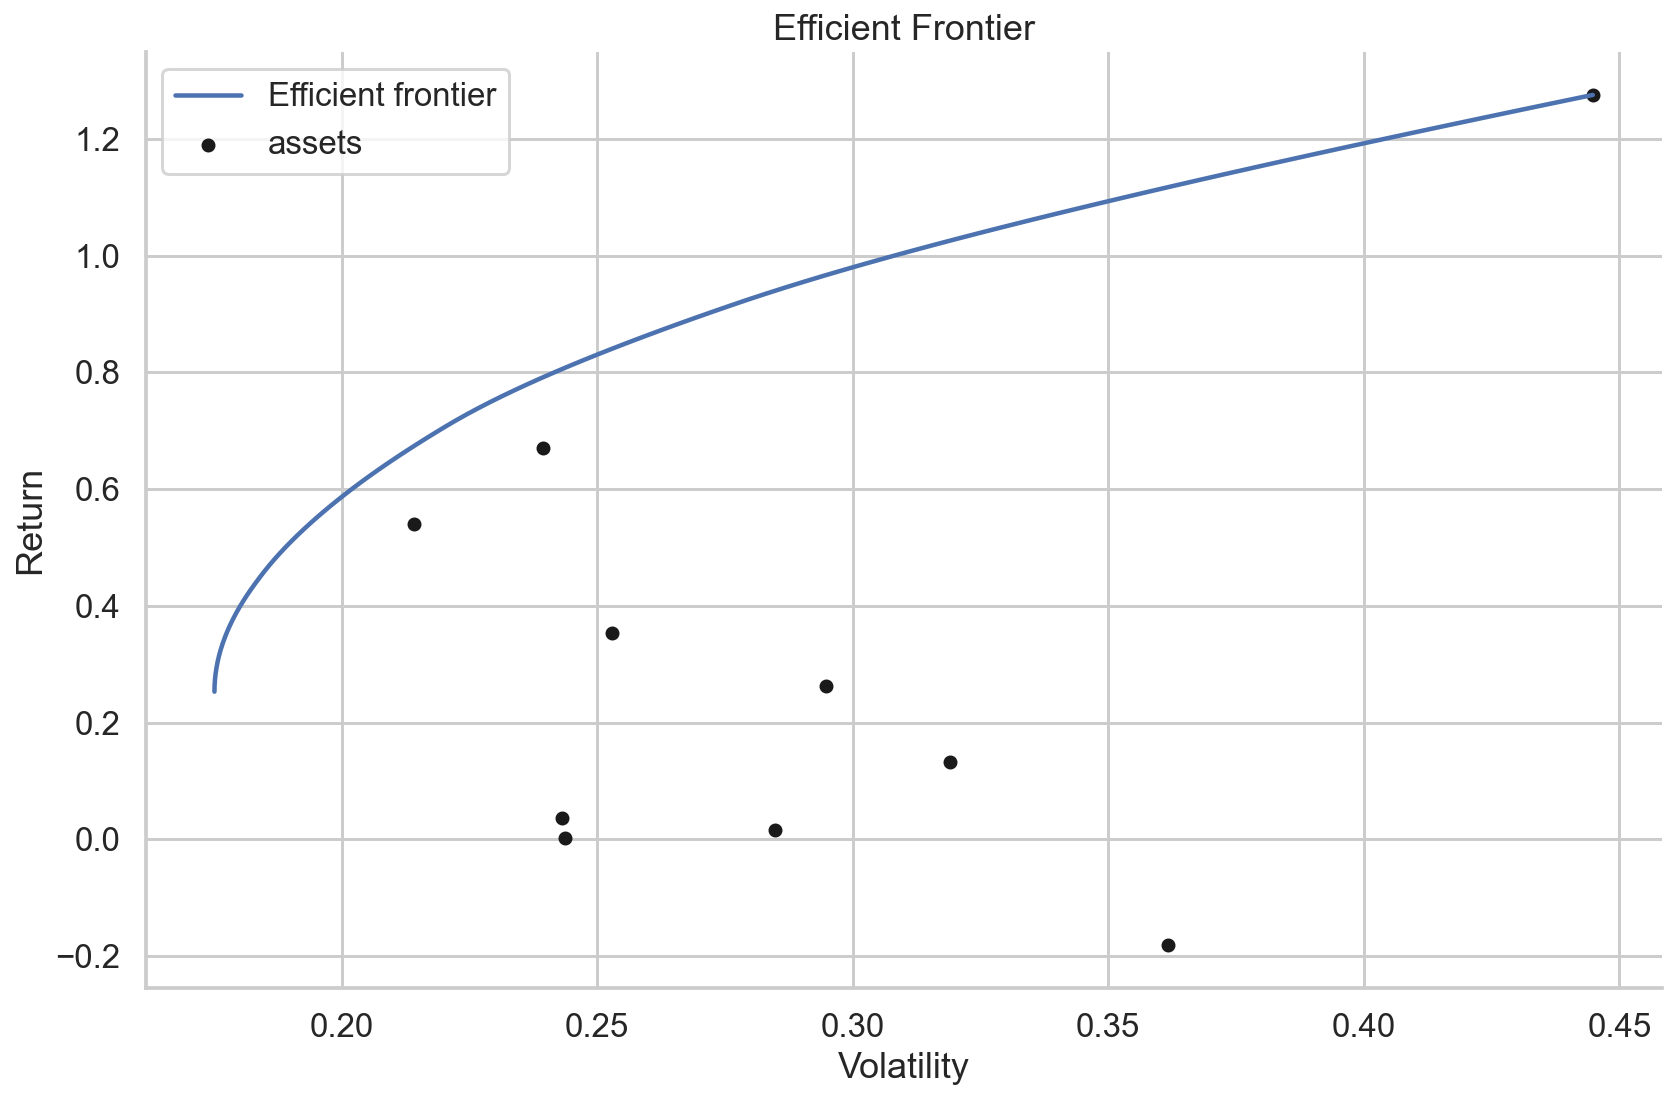

In [72]:
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title("Efficient Frontier")


sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_19", dpi=200)

4. Identify the tangency portfolio:

In [73]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())


OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('GOOG', 0.55146), ('MA', 0.0), ('META', 0.0), ('MSFT', 0.11808), ('NFLX', 0.0), ('NVDA', 0.33046), ('PYPL', 0.0), ('V', 0.0)])


In [74]:
ef.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 85.5%
Annual volatility: 25.7%
Sharpe Ratio: 3.32


We get a warning when we are trying to use a different risk-free rate as the one used for finding the tangency portfolio.

In [75]:
ef.portfolio_performance(verbose=True);

Expected annual return: 85.5%
Annual volatility: 25.7%
Sharpe Ratio: 3.32


/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:438: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


5. Add L2 regularization to the portfolio optimization problem:

In [76]:
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.2)

weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())

OrderedDict([('AAPL', 0.05655), ('AMZN', 0.0), ('GOOG', 0.29756), ('MA', 0.0), ('META', 0.0), ('MSFT', 0.20673), ('NFLX', 0.0), ('NVDA', 0.43917), ('PYPL', 0.0), ('V', 0.0)])


/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


6. Find the tangency portfolio with short-selling allowed:

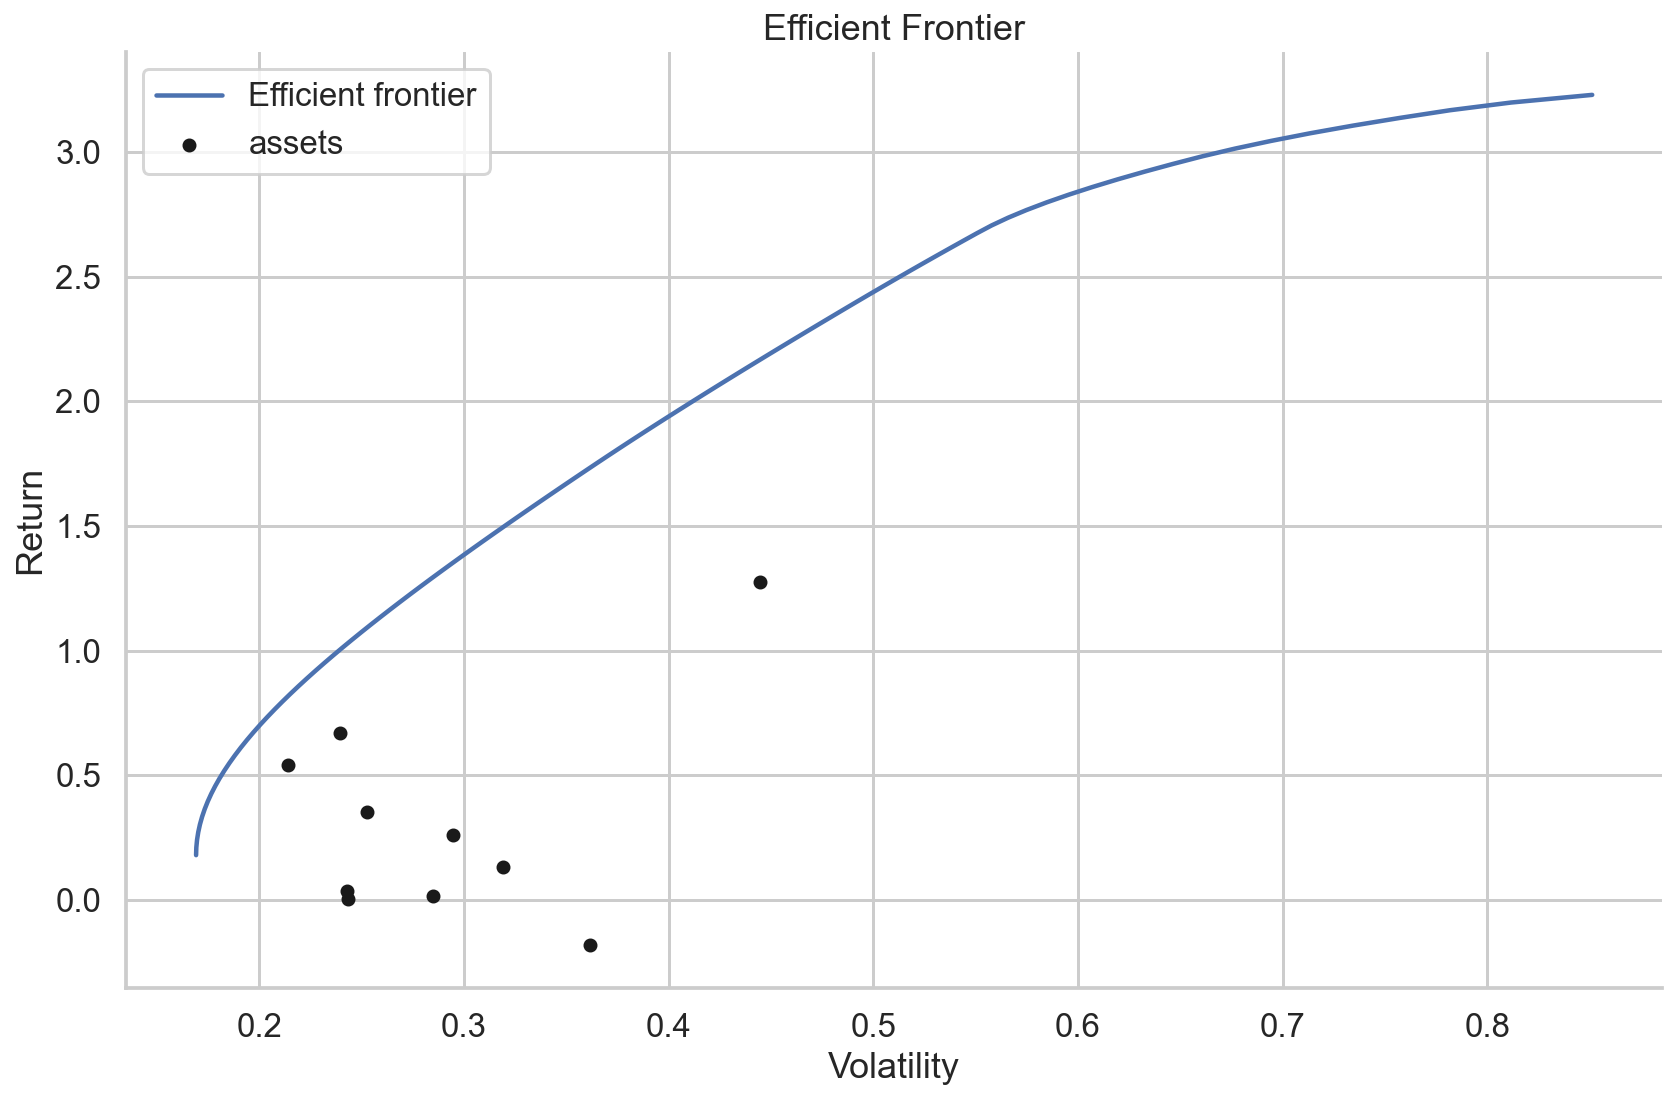

In [77]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title("Efficient Frontier")


sns.despine()
plt.tight_layout()

In [78]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())

OrderedDict([('AAPL', 0.19752), ('AMZN', -0.98181), ('GOOG', 1.0), ('MA', -0.07171), ('META', -0.00017), ('MSFT', 0.9239), ('NFLX', -0.1608), ('NVDA', 0.80187), ('PYPL', -0.80655), ('V', 0.09775)])


In [79]:
ef.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 235.2%
Annual volatility: 48.2%
Sharpe Ratio: 4.88
